In [3]:
'''
METODOLOGÍA

A Continuación, se presenta la metodología de evaluación comparativa de
tres modelos de clasificación para predecir la columna "not.fully.paid",
de acuerdo al dataset adquirido. Esta evaluación se llevará a cabo apli-
cando redes neuronales artificiales (ANN), redes neuronales para K medias
(KNN), y redes neuronales convolucionales (CNN).Se empieza con el respec-t
ivo setup e importanción de las librerías con sus debidos parámetros para
las gráficas a emplear en la primera celda, siendo la segunda y la tercera
de la obtención de los dataframes, incluyendo la codificación de cada pro-
pósito de préstamo, inlcuyendo el "home_improvement", el cual no se encon
traba en el documento guía. Seguidamente, en la cuarta celda se procede a
realizar un análisis estadístico del dataset.
'''
#Importar librerias

import pandas as pd
import neurolab as nl
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
import random

#Ajustar tamaño de graficas
plt.rcParams['figure.figsize'] = [10, 7]
#Desactivar Warnings de Referenciado en pandas
pd.options.mode.chained_assignment = None

In [4]:
'''

'''

#Load CSV Data

with open(r"Data\Proy_Final_data.csv") as file:
    Data = pd.read_csv(file, sep= ",")

#Eliminar columna indice
Data = Data.drop({"Unnamed: 0"}, axis="columns")

print("-------------------------------")
print("Data Cargada: ")
print(Data.head(4))
print("-------------------------------")
print("Informacion del Dataset: ")
print(Data.info())
print("-------------------------------")

-------------------------------
Data Cargada: 
   credit.policy             purpose  int.rate  installment  log.annual.inc  \
0              1         credit_card    0.1505       277.53       11.289782   
1              1  debt_consolidation    0.1253       133.87       10.596635   
2              1  debt_consolidation    0.1392       682.74       11.350407   
3              0           all_other    0.0768       405.48       10.736310   

     dti  fico  days.with.cr.line  revol.bal  revol.util  inq.last.6mths  \
0  12.07   667        3509.041667       9229        93.2               1   
1  18.39   687        4050.000000       7227        70.9               0   
2  11.55   697        5220.000000      17250        78.3               2   
3  23.64   712        3240.000000      58996        55.7               3   

   delinq.2yrs  pub.rec  not.fully.paid  
0            0        0               0  
1            0        0               0  
2            1        0               0  
3       

In [5]:
#Codificacion de propositos
'''
    
'''
#Valores unicos de la columna de propositos
print("-------------------------------")
print("Valores unicos de la columna de propositos: ")
print(Data["purpose"].unique())
print("-------------------------------")

#Asignacion de valores numericos
Purposes = {
    "credit_card" : 0,
    "debt_consolidation" : 1,
    "educational" : 2,
    "major_purchase" : 3,
    "small_business" : 4,
    "all_other" : 5,
    "home_improvement" : 6
}

#Copia de dataset
CodedData = Data.copy()

#Asignacion de codigos a propositos
index = 0
for Purpose in Data["purpose"]:
    for UniquePurpose in Purposes:
        if UniquePurpose == Purpose:
            CodedData["purpose"][index] = Purposes[UniquePurpose] 
    index = index + 1

CodedData = CodedData.apply(pd.to_numeric)

#Dataset Codificado
print("-------------------------------")
print("Dataset Codificado: ")
print(CodedData.head())
print("-------------------------------")

-------------------------------
Valores unicos de la columna de propositos: 
['credit_card' 'debt_consolidation' 'all_other' 'major_purchase'
 'home_improvement' 'small_business' 'educational']
-------------------------------
-------------------------------
Dataset Codificado: 
   credit.policy  purpose  int.rate  installment  log.annual.inc    dti  fico  \
0              1        0    0.1505       277.53       11.289782  12.07   667   
1              1        1    0.1253       133.87       10.596635  18.39   687   
2              1        1    0.1392       682.74       11.350407  11.55   697   
3              0        5    0.0768       405.48       10.736310  23.64   712   
4              1        3    0.1537       174.24       10.463103  11.67   672   

   days.with.cr.line  revol.bal  revol.util  inq.last.6mths  delinq.2yrs  \
0        3509.041667       9229        93.2               1            0   
1        4050.000000       7227        70.9               0            0   
2     

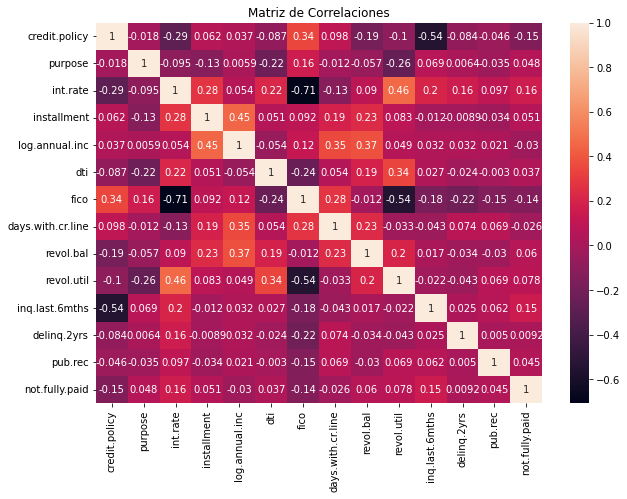

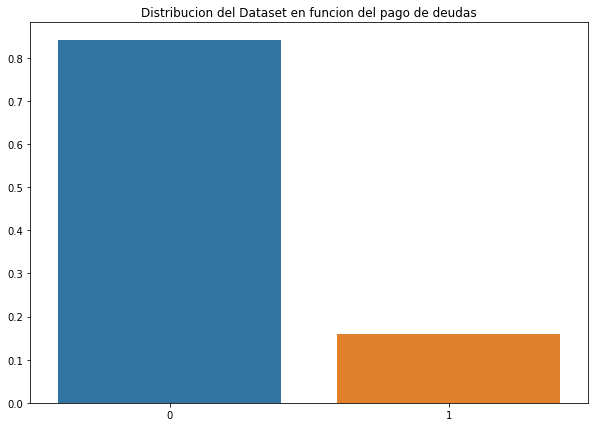

<Figure size 720x504 with 0 Axes>

In [6]:
'''
-ANÁLISIS ESTADÍSTICO DEL DATASET
En esta sección, se busca conocer a profundidad el comportamiento
del dataset a través de métodos estocásticos. Pero se debe tener
en cuenta que como se aplicarán distintos métodos de clasificación
para todos los modelos, es necesario normalizar las variables de
manera que cada una de ellas sean comparables entre sí, de manera que se sepa qué
variables se relacionan en cierta medida a la variable de interés
Para ello, se realiza un estudio de correlación, que brinda la 
librería "Seaborn", de cada  variable codificada en la celda anterior,
de la cual se observa que ninguna variable pertinente como es el caso 
actual de "not.fully.paid" se correlaciona directamente con las 
entradas; esto lo hace apto para aplicar métodos de clasificación.

'''
#Estadisticos del Dataset

#Correlacion entre variables
Correlation = CodedData.corr()
sns.heatmap(Correlation, annot=True)
plt.title("Matriz de Correlaciones")
plt.figure(1)
plt.show()

#Grafico de distribucion del dataset
sns.barplot(x = (CodedData["not.fully.paid"].unique()), 
            y = CodedData.pivot_table(columns = ["not.fully.paid"], aggfunc = 'size')/CodedData.shape[0])
plt.title("Distribucion del Dataset en funcion del pago de deudas")
plt.figure(2)
plt.show()

In [42]:
'''
DATOS DE PRUEBA Y ENTRENAMIENTO
Seguidamente, se establecen los datos de prueba y entrenamiento
donde se define la variable de interés, la cual es "not.fully.paid" del cual
se basan los debidos valores para aprobación y reprobación del préstamo.
Debido a que, se tiene una cantidad reducida de muestras de los aprobados,
se selecciona el 10% del dataset original para realizar las pruebas de 
balanceo de éste de manera que no haya desproporcionalidad dentro de los
datos de interés. Luego, la definición de los datos de entrenamiento cor-
responden a cada concatenación de los créditos aprobados y no aprobados,
que proceden a ser normalizados para emplear las tres técnicas de clasi-
ficación seleccionadas, las cuales son: Perceptrón de única capa, KNN 
(k-nearest neighbors), y el Naive Bayes gaussiano. Estos métodos son 
evaluados mediante el accuracy y el área de la curva caractrística de
operación receptora (ROC, por sus siglas en inglés), como medidas de 
rendimiento.
'''
#Almacenado Dataset De prueba y  entrenamiento 

#Division de creditos aprobados y rechazados
RejectedDT = CodedData.loc[CodedData["not.fully.paid"] == 0].copy()
AProvedDT = CodedData.loc[CodedData["not.fully.paid"] == 1].copy()

NRejected = CodedData.pivot_table(columns = ["not.fully.paid"], aggfunc = 'size')[0]

#Seleccion de dataset de prueba balanceado (10% del dataset original)
AprovedTestDT = AProvedDT.sample(frac = 0.10, random_state = random.randrange(100,1000))
NAprovedTest = AprovedTestDT.shape[0]
RejectedTestDT = RejectedDT.sample(frac = NAprovedTest/NRejected, random_state = random.randrange(100,1000))
NRejectedTest = RejectedTestDT.shape[0]

#Dataset de entrenamiento
AprovedTrainDT = AProvedDT.drop(AprovedTestDT.index)
AprovedTrainDT = AprovedTrainDT.reset_index(drop = True)
RejectedTrainDT = RejectedDT.drop(RejectedTestDT.index)
RejectedTrainDT = RejectedTrainDT.reset_index(drop = True)

TrainDT = pd.concat([AprovedTrainDT, RejectedTrainDT], axis = 0, copy = True, ignore_index = True)
TrainDT = TrainDT.reset_index(drop = True)

TestDT = pd.concat([AprovedTestDT, RejectedTestDT], axis = 0, copy = True, ignore_index = True)
TestDT = TestDT.reset_index(drop = True)

In [8]:
#Metodologia de Dataset Completo

#Normalizar el Dataset
NormalizedData = (TrainDT - TrainDT.min())/(TrainDT.max() -TrainDT.min())

Accuracy:  0.8511627906976744


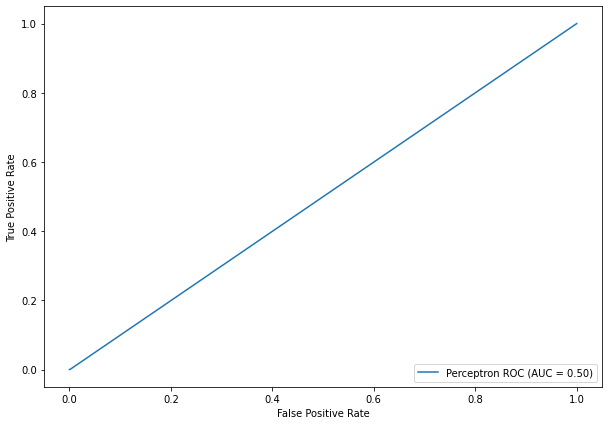

In [9]:
'''
DISEÑO DE PERCEPTRÓN DE CAPA DE ÚNICA
Ahora bien, en lo que respecta de la aplicación del primer método, 
el perceptrón de única capa, se procede a separar y seleccionar los
pesos por cada clase a entrenar, donde la clase "0" tendrá un 30%
mayor de predominancia que la clase 1, de manera que sean menos los
créditos que se pierden, pues es más factible para el banco, constar
de más créditos aprobados que debían ser negados que lo contrario a 
esto. Todo esto gracias a la función "train_test_split" brindada por
la libraría "Sklearn" para subsets de entretamiento y prueba aleatórios.
Posteriormente, se generan los niveles de accuracy para seleccionar el 
modelo, y de igual forma adquirir los falsos positivos y verdaderos
positivos, para generar la curva ROC. Dicho esto, se aplica el mismo
procedimiento para los modelos de clasificación.

'''
#Perceptron de unica capa
XTrain, XTest, YTrain, YTest = train_test_split(NormalizedData.drop(["not.fully.paid"], axis = 1), 
                                                NormalizedData["not.fully.paid"],
                                                test_size = 0.3)

clf = Perceptron(tol=1e-3, random_state= random.randrange(1,9999), n_jobs = 8, class_weight= {0:1, 1:0.7} , max_iter = 2000)
clf.fit(XTrain, YTrain)
YPredict = clf.predict(XTest)

print("Accuracy: ", metrics.accuracy_score(YTest, YPredict))
#Curva ROC
fpr, tpr, tresh = metrics.roc_curve(YTest, YPredict)
roc_auc = metrics.auc(fpr, tpr)
RocCurve = metrics.RocCurveDisplay(fpr = fpr,tpr = tpr, roc_auc = roc_auc, estimator_name = "Perceptron ROC")
RocCurve.plot()
plt.show()

pickle.dump(clf, open(r"OutPut\ANN\FullDataset\Network_Dataset_Completo", "wb"))

Accuracy:  0.854122621564482


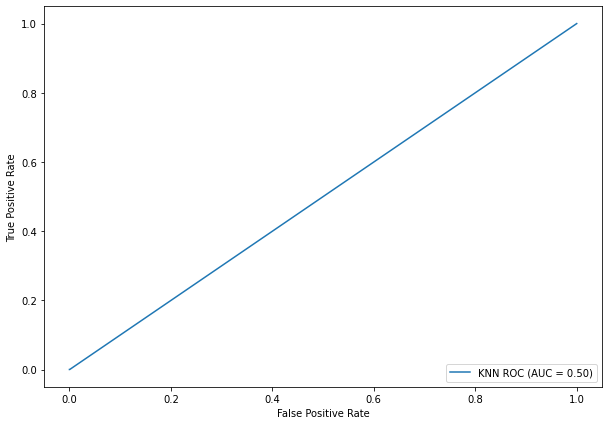

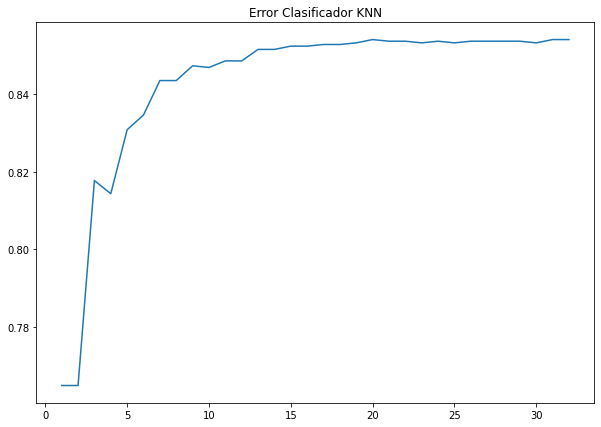

In [10]:
'''
DISEÑO DE KNN
Ahora bien, ocurre el mismo proceso que el método anterior, donde además se
busca incrementar el valor de K, y se obtenga una reducción del 5% respecto
al anterior para adqurir el modelo adecuado frente a dicho criterio.

'''
#Clasificador KNN

XTrain, XTest, YTrain, YTest = train_test_split(NormalizedData.drop(["not.fully.paid"], axis = 1), 
                                                NormalizedData["not.fully.paid"],
                                                test_size = 0.3)

K = 1
LastAccuracy = 0

KNNmodel = KNeighborsClassifier(n_neighbors=K)
KNNmodel.fit(XTrain, YTrain)
YPredict = KNNmodel.predict(XTest)
Accuracy = metrics.accuracy_score(YTest, YPredict)

AccuracyPlot = np.array(Accuracy)
KPlot = np.array(K)

o = 0
while (Accuracy > LastAccuracy*0.99) and (o <= 10):
    K = K + 1
    KNNmodel = KNeighborsClassifier(n_neighbors=K, n_jobs = 8, weights = 'distance')
    KNNmodel.fit(XTrain, YTrain)
    YPredict = KNNmodel.predict(XTest)
    LastAccuracy = Accuracy
    Accuracy = metrics.accuracy_score(YTest, YPredict)

    AccuracyPlot = np.append(AccuracyPlot, Accuracy)
    KPlot = np.append(KPlot, K)

    if (round(Accuracy,5) == round(LastAccuracy,5)):
        o = o + 1

print("Accuracy: ", metrics.accuracy_score(YTest, YPredict))

#Curva Roc
fpr, tpr, tresh = metrics.roc_curve(YTest, YPredict)
roc_auc = metrics.auc(fpr, tpr)
RocCurve = metrics.RocCurveDisplay(fpr = fpr,tpr = tpr, roc_auc = roc_auc, estimator_name = "KNN ROC")
RocCurve.plot()
plt.show()

#Curva Accuracy
plt.plot(KPlot, AccuracyPlot)
plt.title("Error Clasificador KNN")
plt.show()

pickle.dump(KNNmodel, open("OutPut\KNN\FullDataset\KNN_FullDataset", "wb"))

Accuracy:  0.7572938689217759


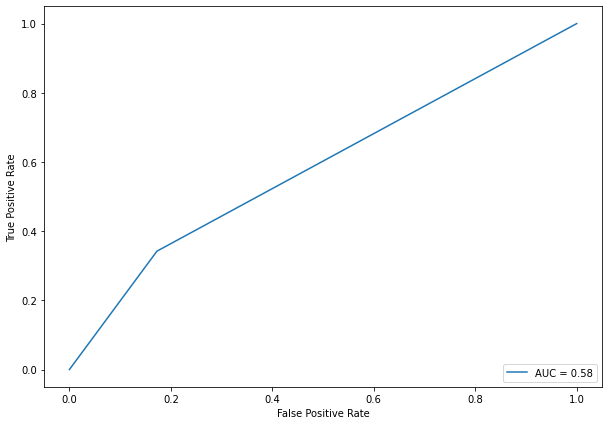

In [11]:
''''
DISEÑO DE NAIVE BAYES GAUSSEAN
En este, ocurre un proceso similar como en el perceptrón de capa única
a diferencia que los pesos en este método son evaluados de forma di-
ferente; esto es, la suma de los números es igual a 1, y la clase 0 
tiene un 20% mayor de probabilidad para ser escogida como el modelo
generativo.
'''
#Clasificador Naive Bayes Gaussiano

XTrain, XTest, YTrain, YTest = train_test_split(NormalizedData.drop(["not.fully.paid"], axis = 1), 
                                                NormalizedData["not.fully.paid"],
                                                test_size = 0.3)

BayesModel = GaussianNB(priors = [0.6,0.4])
BayesModel.fit(XTrain, YTrain)
YPredict = BayesModel.predict(XTest)

print("Accuracy: ", metrics.accuracy_score(YTest, YPredict))
#Curva Roc
fpr, tpr, tresh = metrics.roc_curve(YTest, YPredict)
roc_auc = metrics.auc(fpr, tpr)
RocCurve = metrics.RocCurveDisplay(fpr = fpr,tpr = tpr, roc_auc = roc_auc)
RocCurve.plot()
plt.show()
pickle.dump(KNNmodel, open("OutPut\BAYES\FullDataset\Bayes_FullDataset", "wb"))

Cantidades de creditos aprobados
1173
Candidades de creditos rechazados
6708
Numero de submuestras
5.718670076726343
Submuestras: 
(2346, 14)


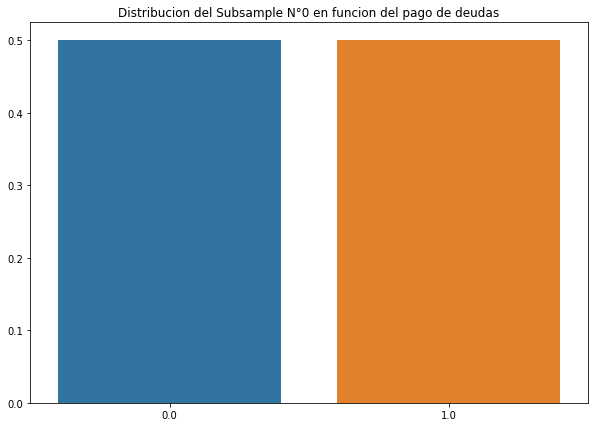

<Figure size 720x504 with 0 Axes>

(2346, 14)


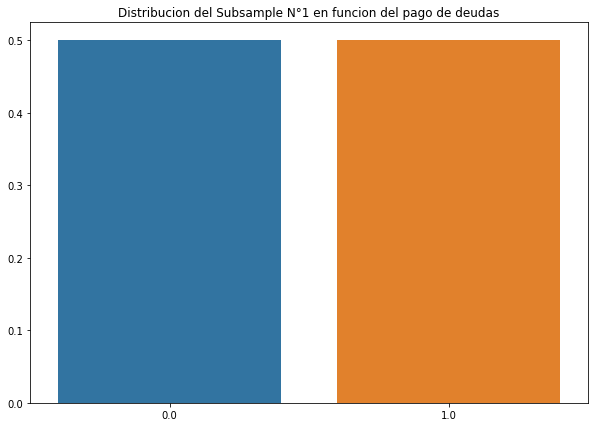

<Figure size 720x504 with 0 Axes>

(2346, 14)


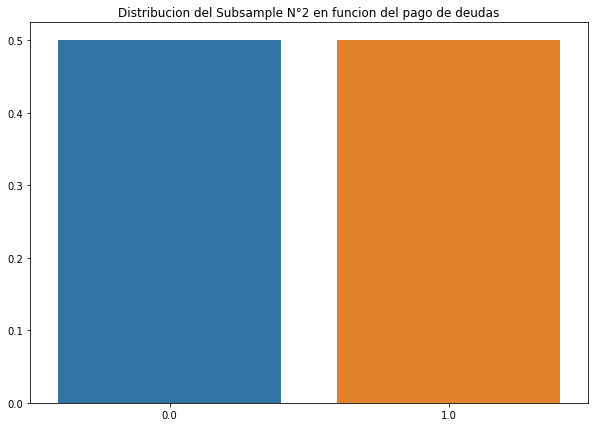

<Figure size 720x504 with 0 Axes>

(2346, 14)


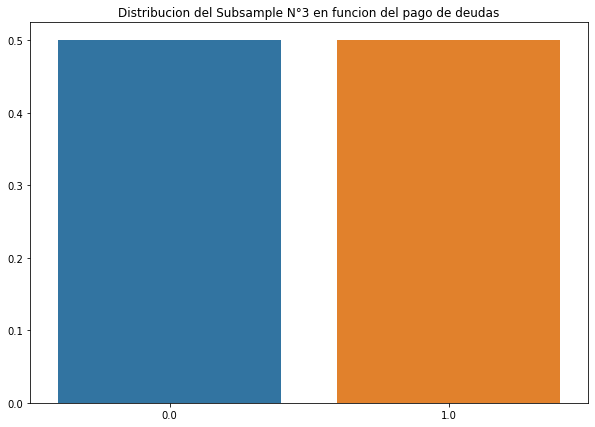

<Figure size 720x504 with 0 Axes>

(2346, 14)


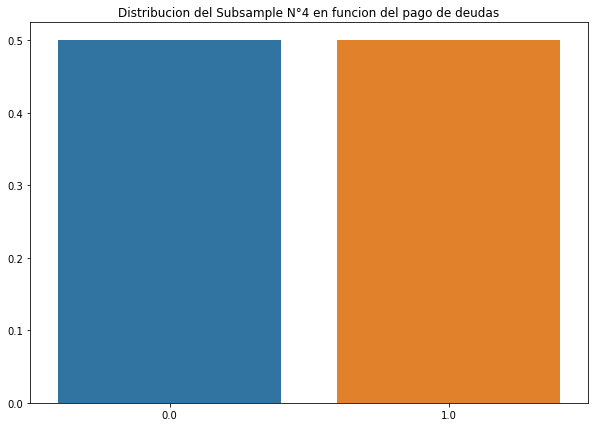

<Figure size 720x504 with 0 Axes>

In [12]:
'''
BALANCEO POR SUBMUESTREO DE LA CLASE MAYORITARIA
Como bien se mencionó, los datos actuales implementado en
ete algoritmo, se encontraban imbalanceados; por tanto, se
procede a aplicar primero como método de balanceo el submu-
estreo de la clase mayoritaria, que en este es el 0. 
Esto se hace primero, estableciendo las cantidades y crédi-
tos aprobados y rechazados, siendo el número de muestras 
la división entre la última sobre la primera. De allí se
establece el submuestreo como la fracción de una unidad
sobre la diferencia del número de muestras con el incremento
i, de una serie aleatoria, generada por la función "sample".
'''
#Metodologia de Balanceo por submuestreo de la clase mayoritaria

NAproved = TrainDT.pivot_table(columns = ["not.fully.paid"], aggfunc = 'size')[1]
NRejected = TrainDT.pivot_table(columns = ["not.fully.paid"], aggfunc = 'size')[0]
NSubsamples = (NRejected/NAproved)
print("Cantidades de creditos aprobados")
print(NAproved)
print("Candidades de creditos rechazados")
print(NRejected)
print("Numero de submuestras")
print(NSubsamples)

RejectedDT = NormalizedData.loc[NormalizedData["not.fully.paid"] == 0].copy()
AProvedDT = NormalizedData.loc[NormalizedData["not.fully.paid"] == 1].copy()

Subsamples = list()
for i in range(int(NSubsamples)):
    Subsample = RejectedDT.sample(frac = 1/(NSubsamples - i), random_state = random.randrange(100,1000))
    RejectedDT = RejectedDT.drop(Subsample.index)
    Subsample = pd.concat([Subsample, AProvedDT])
    Subsample = Subsample.reset_index(drop = True)
    Subsamples.append(Subsample)

print("Submuestras: ")
z = 0
for Subsample in Subsamples:
    print(Subsample.shape)
    sns.barplot(x = (Subsample["not.fully.paid"].unique()), 
            y = Subsample.pivot_table(columns = ["not.fully.paid"], aggfunc = 'size')/Subsample.shape[0])
    plt.title("Distribucion del Subsample N°" + str(z) + " en funcion del pago de deudas")
    plt.figure(2)
    plt.show()
    z = z + 1

Accuracy:  0.5355113636363636


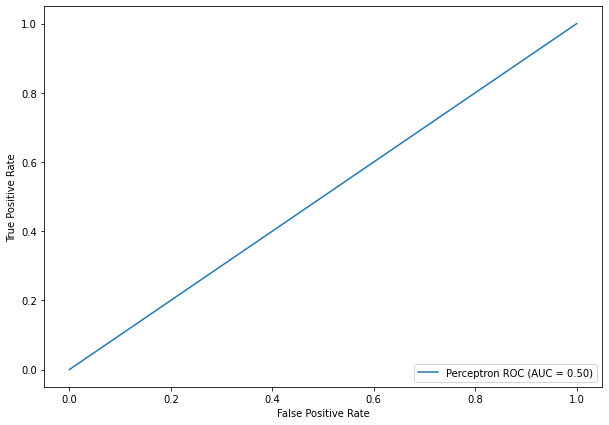

Accuracy:  0.5255681818181818


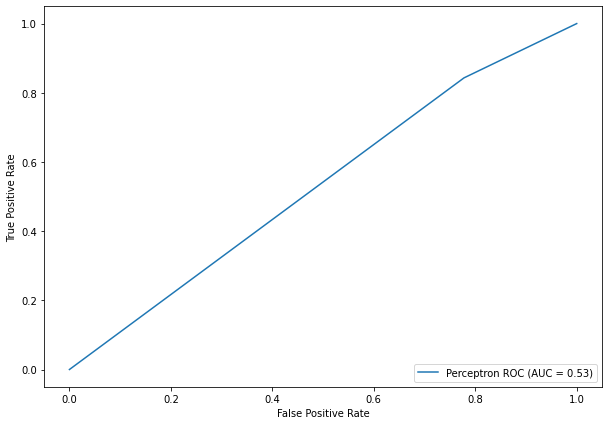

Accuracy:  0.5980113636363636


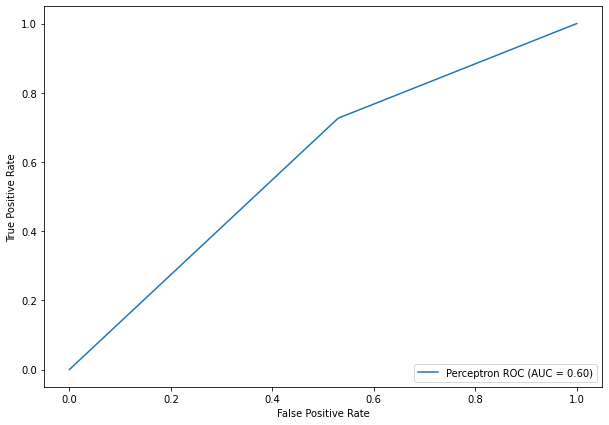

Accuracy:  0.4900568181818182


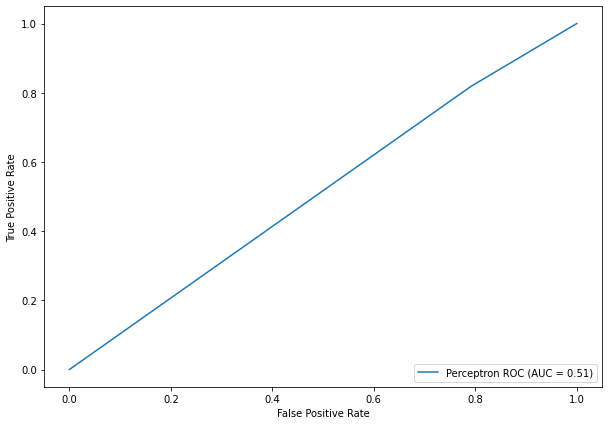

Accuracy:  0.5980113636363636


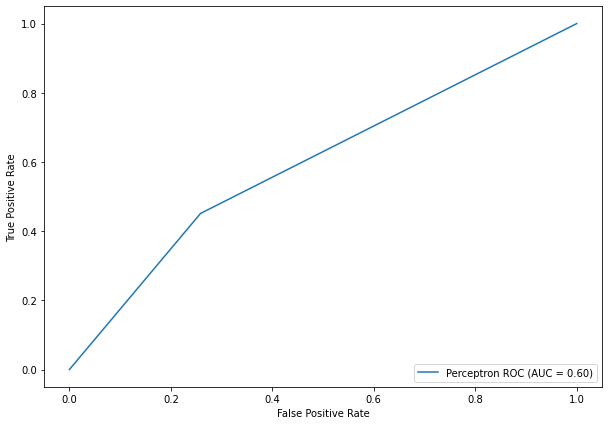

In [13]:
#Perceptron de unica capa

z = 0
clf_list = list()
accuracy_list = list()

for Subsample in Subsamples:
    XTrain, XTest, YTrain, YTest = train_test_split(Subsample.drop(["not.fully.paid"], axis = 1), 
                                                Subsample["not.fully.paid"],
                                                test_size = 0.3)

    
    clf = Perceptron(tol=1e-3, random_state= random.randrange(1,9999), n_jobs = 8, class_weight= {0:1, 1:0.7} , max_iter = 2000)
    clf.fit(XTrain, YTrain)
    YPredict = clf.predict(XTest)
    
    #Accuracy
    print("Accuracy: ", metrics.accuracy_score(YTest, YPredict))
    accuracy_list.append(metrics.accuracy_score(YTest, YPredict))
    clf_list.append(clf)

    #Curva ROC
    fpr, tpr, tresh = metrics.roc_curve(YTest, YPredict)
    roc_auc = metrics.auc(fpr, tpr)
    RocCurve = metrics.RocCurveDisplay(fpr = fpr,tpr = tpr, roc_auc = roc_auc, estimator_name = "Perceptron ROC")
    RocCurve.plot()
    plt.show()

    z = z + 1

pickle.dump(clf_list[accuracy_list.index(max(accuracy_list))], open(r"OutPut\ANN\Subsample\Network_Subsample_equal", "wb"))

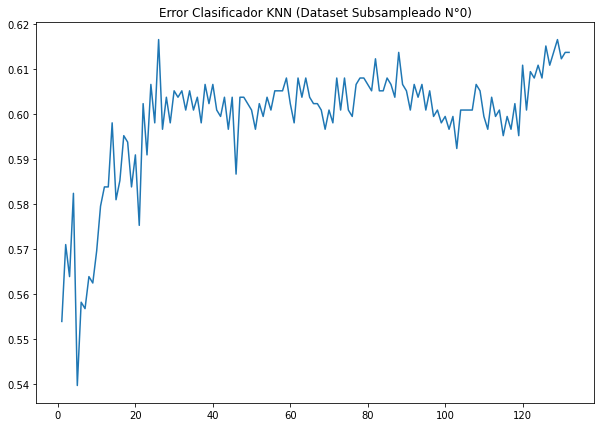

<Figure size 720x504 with 0 Axes>

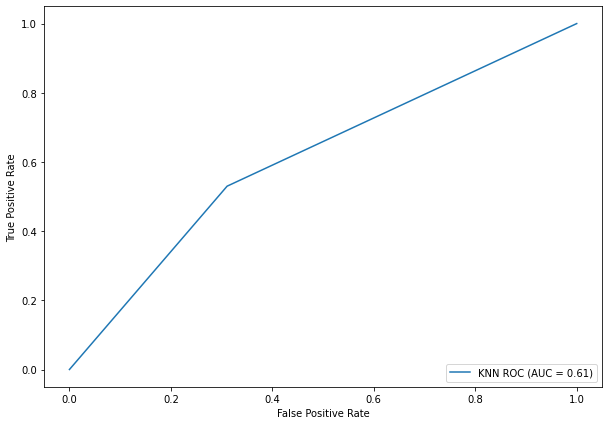

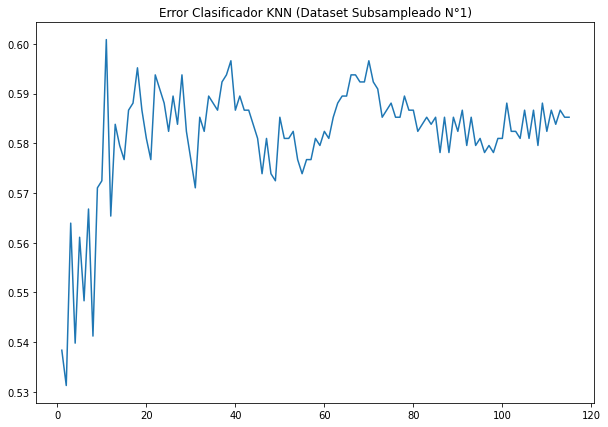

<Figure size 720x504 with 0 Axes>

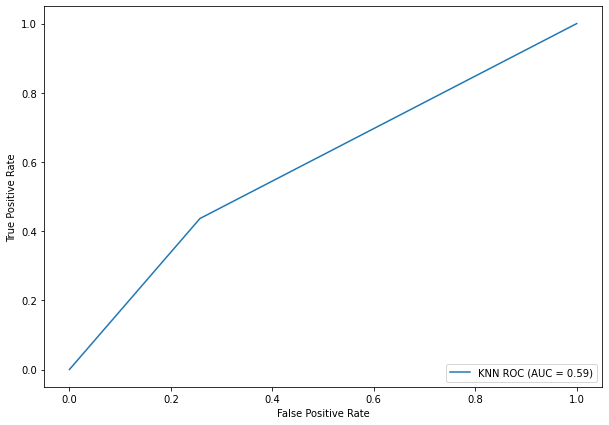

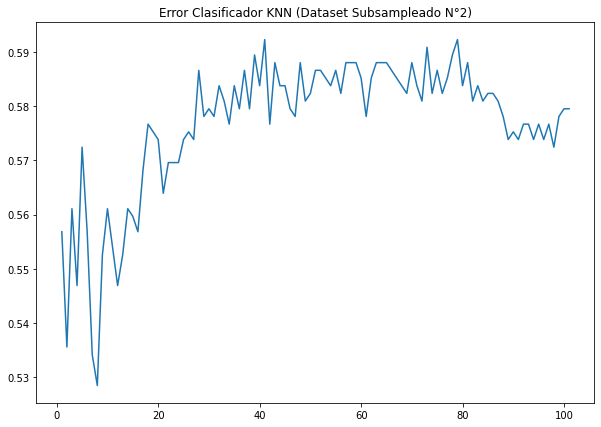

<Figure size 720x504 with 0 Axes>

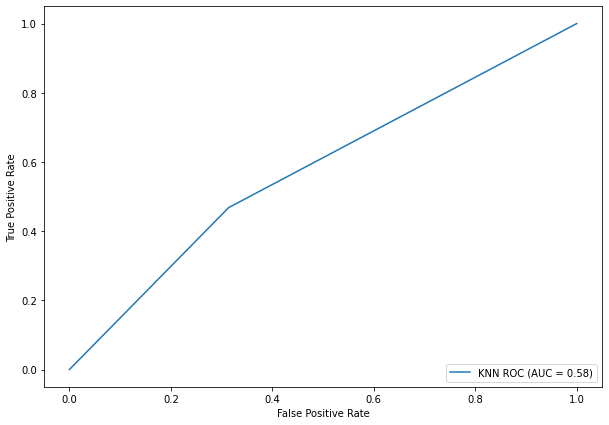

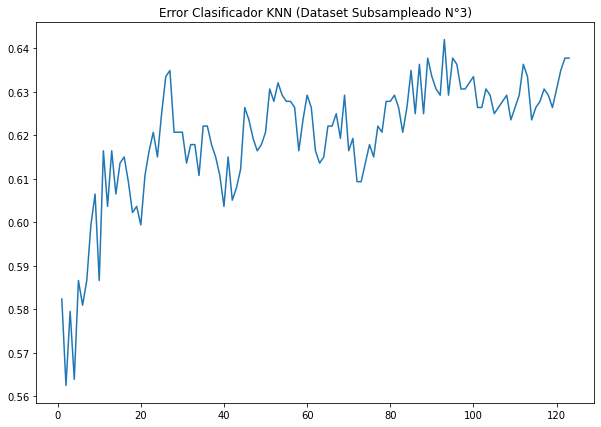

<Figure size 720x504 with 0 Axes>

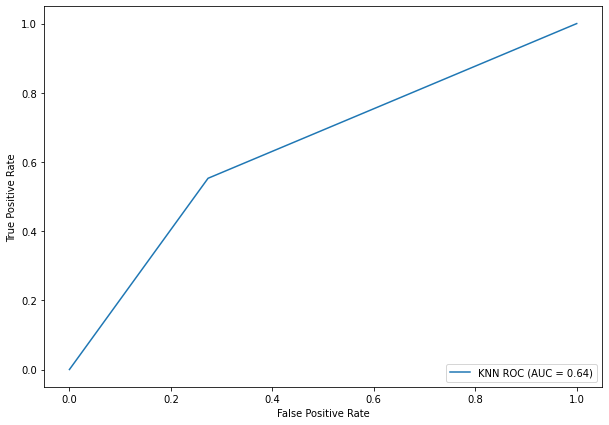

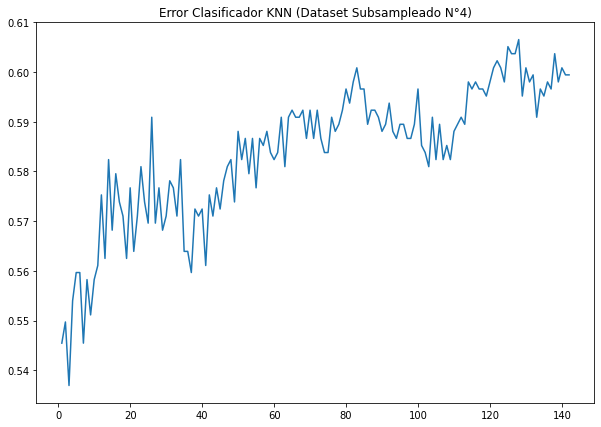

<Figure size 720x504 with 0 Axes>

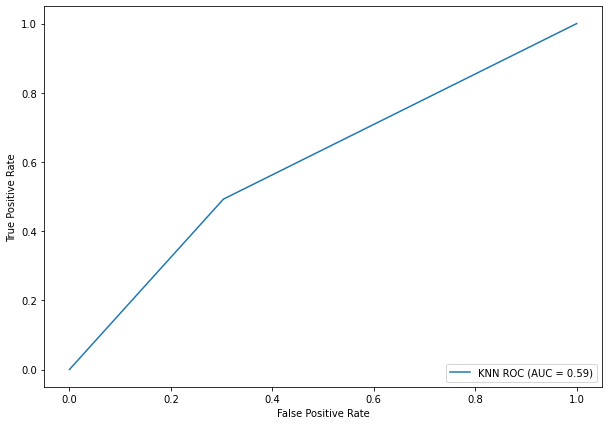

In [14]:
#Clasificador KNN

z = 0
KNN_list = list()
accuracy_list = list()

for subsample in Subsamples:
    XTrain, XTest, YTrain, YTest = train_test_split(Subsample.drop(["not.fully.paid"], axis = 1), Subsample["not.fully.paid"],test_size = 0.3)

    
    K = 1
    LastAccuracy = 0
    KNNmodel = KNeighborsClassifier(n_neighbors=K)
    
    KNNmodel.fit(XTrain, YTrain)
    YPredict = KNNmodel.predict(XTest)
    Accuracy = metrics.accuracy_score(YTest, YPredict)

    AccuracyPlot = np.array(Accuracy)
    KPlot = np.array(K)

    o = 0
    while (Accuracy > LastAccuracy*0.90) and (o <= 10):
        K = K + 1
        KNNmodel = KNeighborsClassifier(n_neighbors=K)
        KNNmodel.fit(XTrain, YTrain)
        YPredict = KNNmodel.predict(XTest)
        LastAccuracy = Accuracy
        Accuracy = metrics.accuracy_score(YTest, YPredict)

        AccuracyPlot = np.append(AccuracyPlot, Accuracy)
        KPlot = np.append(KPlot, K)

        if (round(Accuracy,5) == round(LastAccuracy,5)):
            o = o + 1
    
    KNN_list.append(KNNmodel)
    accuracy_list.append(Accuracy)
    
    plt.plot(KPlot, AccuracyPlot)
    plt.title("Error Clasificador KNN (Dataset Subsampleado N°"+str(z)+")")
    plt.figure(4)
    plt.show()
    
    Error = pd.DataFrame(YTest - YPredict)
    fpr, tpr, tresh = metrics.roc_curve(YTest, YPredict)
    roc_auc = metrics.auc(fpr, tpr)
    RocCurve = metrics.RocCurveDisplay(fpr = fpr,tpr = tpr, roc_auc = roc_auc, estimator_name = "KNN ROC")
    RocCurve.plot()
    plt.show()

    z = z + 1

pickle.dump(KNN_list[accuracy_list.index(max(accuracy_list))], open(r"OutPut\KNN\Subsample\KNN_Subsample", "wb"))

Accuracy:  0.7403805496828753


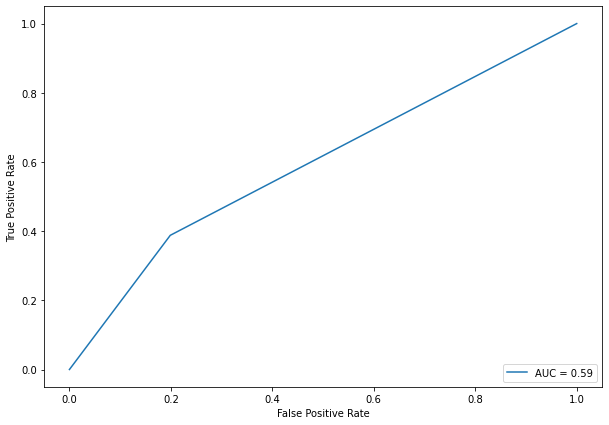

Accuracy:  0.7526427061310782


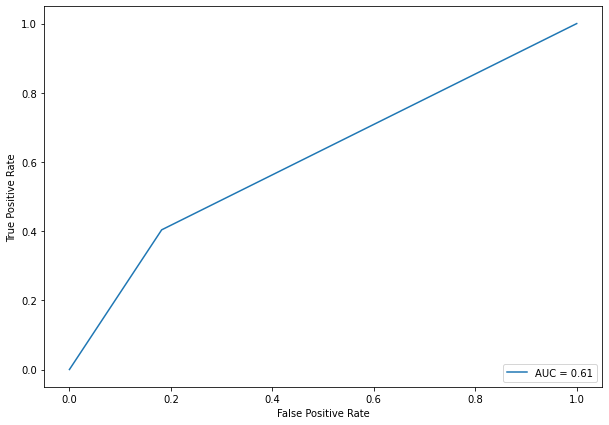

Accuracy:  0.7454545454545455


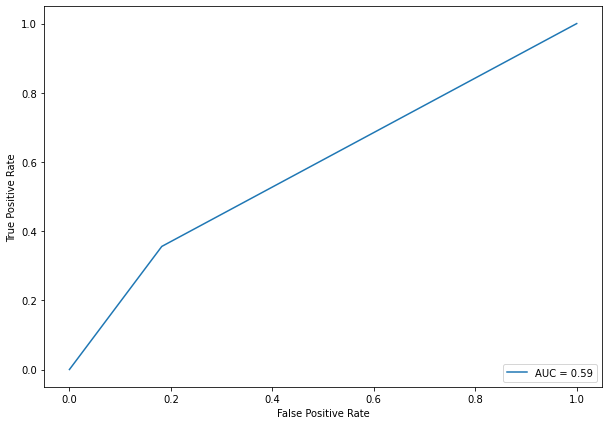

Accuracy:  0.733615221987315


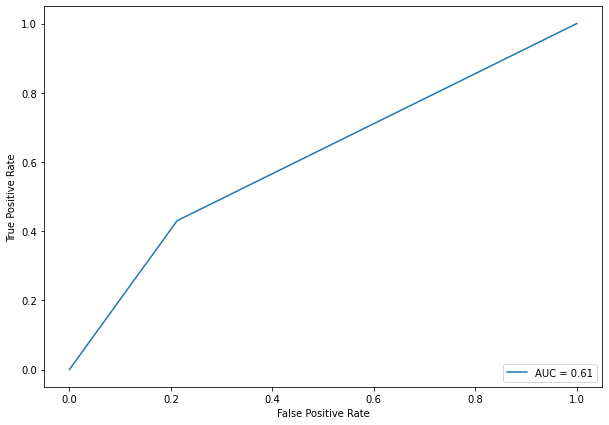

Accuracy:  0.7572938689217759


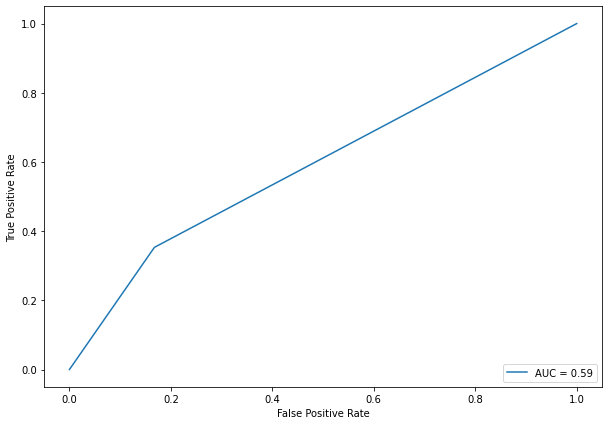

In [27]:
#Clasificador Naive Bayes Gaussiano

z = 0
Bayes_list = list()
accuracy_list = list()

for subsample in Subsamples:
    XTrain, XTest, YTrain, YTest = train_test_split(NormalizedData.drop(["not.fully.paid"], axis = 1), 
                                                    NormalizedData["not.fully.paid"],
                                                    test_size = 0.3)

    BayesModel = GaussianNB(priors = [0.6,0.4])
    BayesModel.fit(XTrain, YTrain)
    YPredict = BayesModel.predict(XTest)

    print("Accuracy: ", metrics.accuracy_score(YTest, YPredict))
    accuracy_list.append(metrics.accuracy_score(YTest, YPredict))
    Bayes_list.append(BayesModel)

    #Curva Roc
    fpr, tpr, tresh = metrics.roc_curve(YTest, YPredict)
    roc_auc = metrics.auc(fpr, tpr)
    RocCurve = metrics.RocCurveDisplay(fpr = fpr,tpr = tpr, roc_auc = roc_auc)
    RocCurve.plot()
    plt.show()

    z = z + 1
    
pickle.dump(Bayes_list[accuracy_list.index(max(accuracy_list))], open("OutPut\BAYES\Subsample\Bayes_Subsample", "wb"))

In [16]:
'''
ENSEMBLE CON SUBMUESTREO
Para el caso del submuestreo con clasificadores ensemble, se opta por
aplicar el tipo paralelo, denominado "bagging", a partir del uso de
los k vecinos de la clase mayoritaria para los diferentes subsets de
entrenamiento establecidos; donde la muestras son seleccionadas de
forma aleatoria. A partir de allí, se emplean los tres distintos 
métodos de clasificación para la selección del modelo.
'''

#Ensemble con submuestreo

Accuracy:  0.5681818181818182


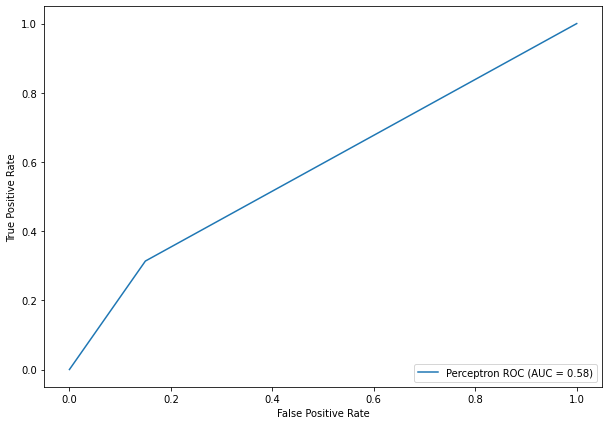

Accuracy:  0.5071022727272727


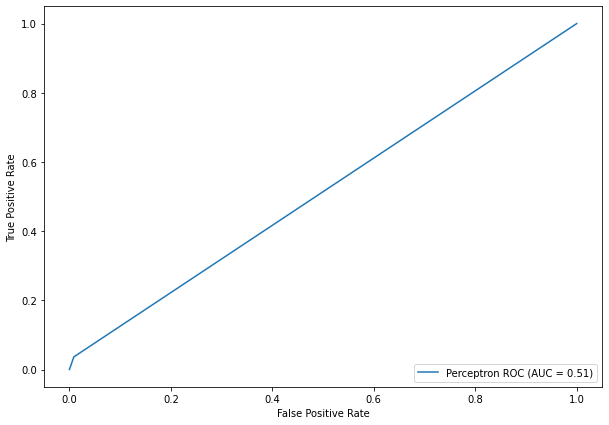

Accuracy:  0.5880681818181818


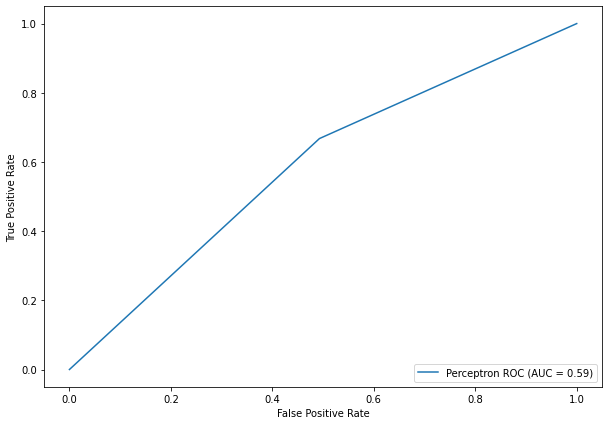

Accuracy:  0.5170454545454546


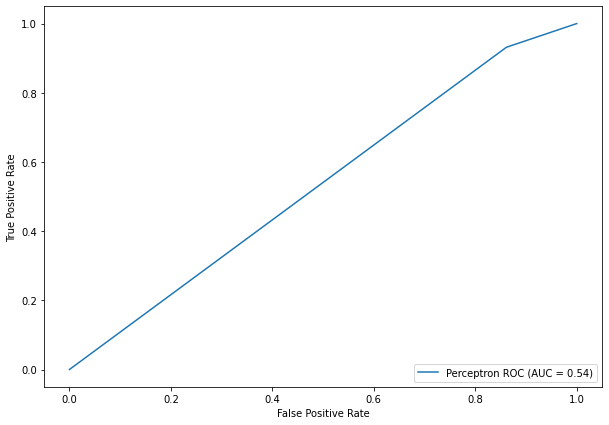

Accuracy:  0.6022727272727273


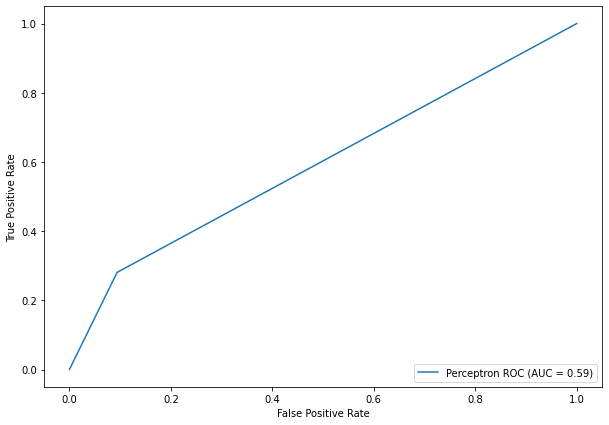

In [28]:
#Perceptron de unica capa

z = 0

for Subsample in Subsamples:
    XTrain, XTest, YTrain, YTest = train_test_split(Subsample.drop(["not.fully.paid"], axis = 1), 
                                                Subsample["not.fully.paid"],
                                                test_size = 0.3)

    clf = Perceptron(tol=1e-3, random_state= random.randrange(1,9999), n_jobs = 8, class_weight= {0:1, 1:0.7} , max_iter = 2000)
    clf.fit(XTrain, YTrain)
    YPredict = clf.predict(XTest)
    
    #Accuracy
    print("Accuracy: ", metrics.accuracy_score(YTest, YPredict))

    #Curva ROC
    fpr, tpr, tresh = metrics.roc_curve(YTest, YPredict)
    roc_auc = metrics.auc(fpr, tpr)
    RocCurve = metrics.RocCurveDisplay(fpr = fpr,tpr = tpr, roc_auc = roc_auc, estimator_name = "Perceptron ROC")
    RocCurve.plot()
    plt.show()

    pickle.dump(clf, open(r"OutPut\ANN\Ensemble\Network_Ensemble_N" + str(z), "wb"))

    z = z + 1


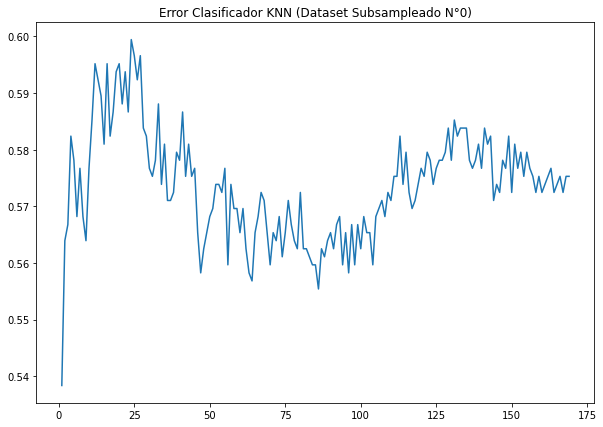

<Figure size 720x504 with 0 Axes>

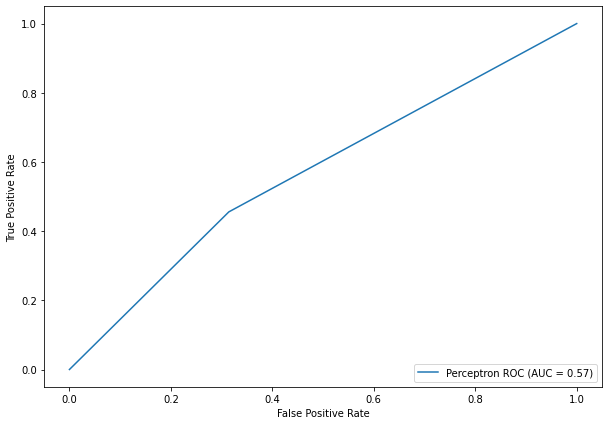

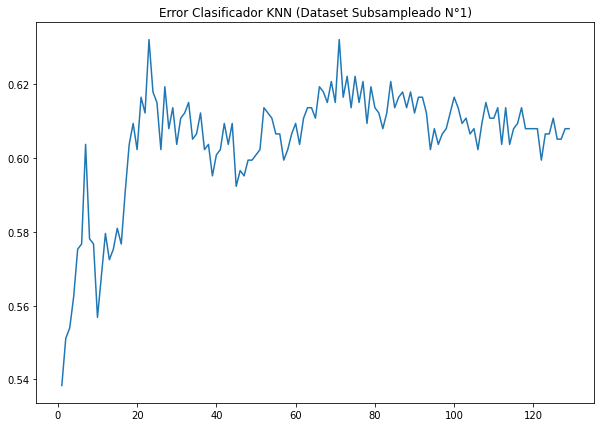

<Figure size 720x504 with 0 Axes>

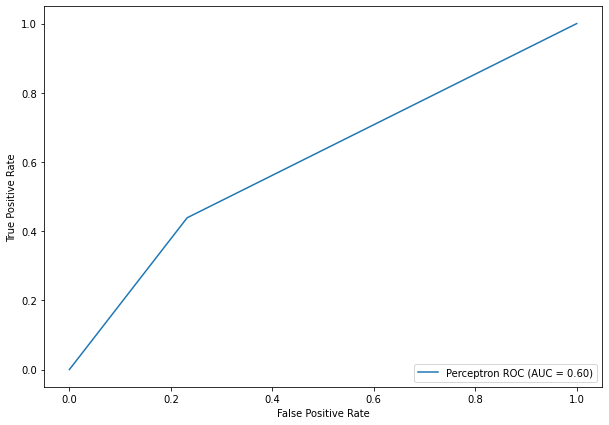

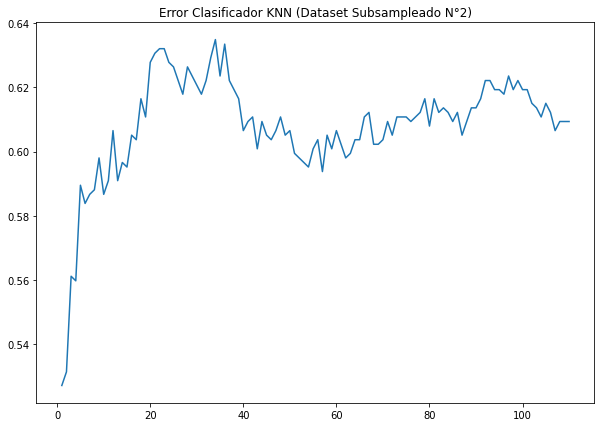

<Figure size 720x504 with 0 Axes>

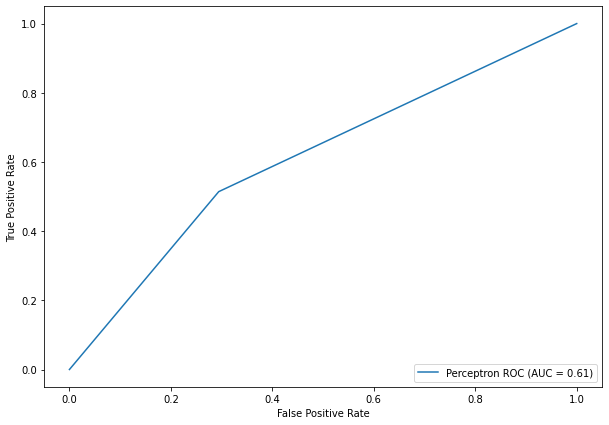

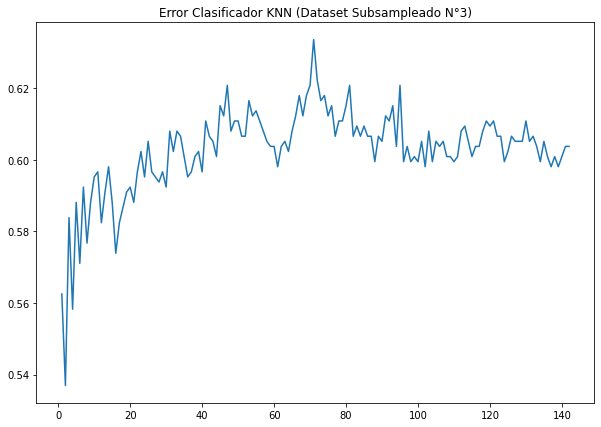

<Figure size 720x504 with 0 Axes>

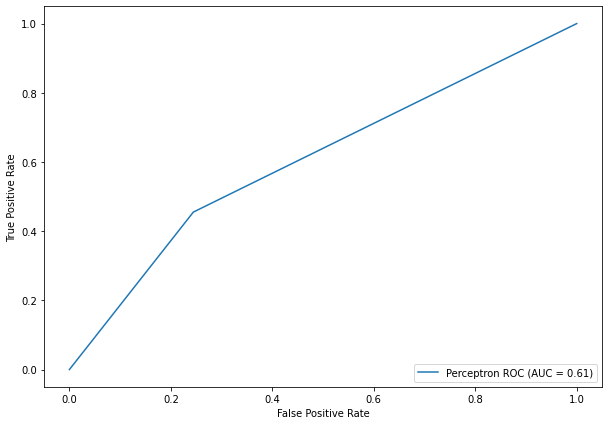

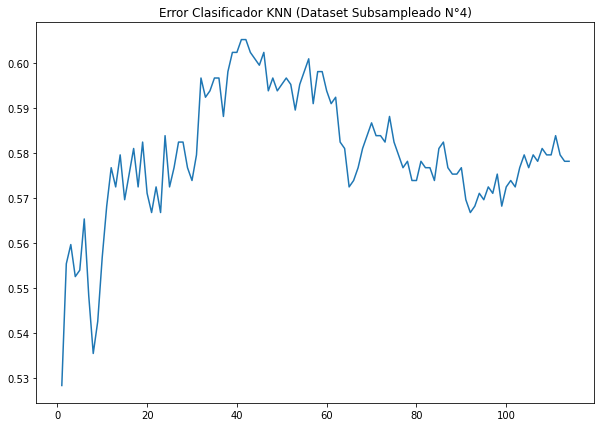

<Figure size 720x504 with 0 Axes>

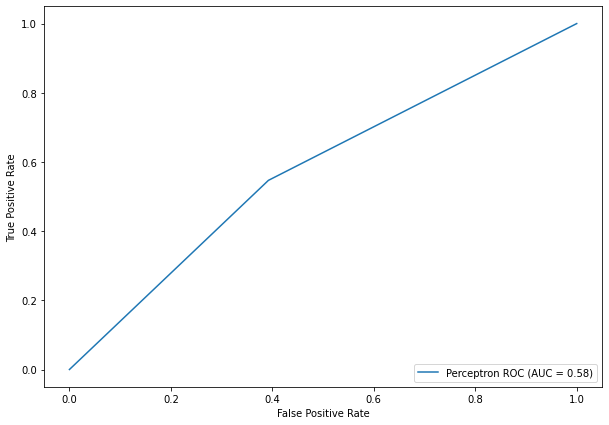

In [29]:
#Clasificador KNN

z = 0
for subsample in Subsamples:

    XTrain, XTest, YTrain, YTest = train_test_split(Subsample.drop(["not.fully.paid"], axis = 1), Subsample["not.fully.paid"],test_size = 0.3)

    K = 1
    LastAccuracy = 0

    KNNmodel = KNeighborsClassifier(n_neighbors=K)
    KNNmodel.fit(XTrain, YTrain)
    YPredict = KNNmodel.predict(XTest)
    Accuracy = metrics.accuracy_score(YTest, YPredict)

    AccuracyPlot = np.array(Accuracy)
    KPlot = np.array(K)

    o = 0
    while (Accuracy > LastAccuracy*0.95) and (o <= 10):
        K = K + 1
        KNNmodel = KNeighborsClassifier(n_neighbors=K)
        KNNmodel.fit(XTrain, YTrain)
        YPredict = KNNmodel.predict(XTest)
        LastAccuracy = Accuracy
        Accuracy = metrics.accuracy_score(YTest, YPredict)

        AccuracyPlot = np.append(AccuracyPlot, Accuracy)
        KPlot = np.append(KPlot, K)
        if (round(Accuracy,5) == round(LastAccuracy,5)):
            o = o + 1

    plt.plot(KPlot, AccuracyPlot)
    plt.title("Error Clasificador KNN (Dataset Subsampleado N°"+str(z)+")")
    plt.figure(4)
    plt.show()

    #Curva ROC
    fpr, tpr, tresh = metrics.roc_curve(YTest, YPredict)
    roc_auc = metrics.auc(fpr, tpr)
    RocCurve = metrics.RocCurveDisplay(fpr = fpr,tpr = tpr, roc_auc = roc_auc, estimator_name = "Perceptron ROC")
    RocCurve.plot()
    plt.show()
    
    pickle.dump(KNNmodel, open(r"OutPut\KNN\Ensemble\KNN_Ensemble_N" + str(z), "wb"))
    z = z + 1

Accuracy:  0.5980113636363636


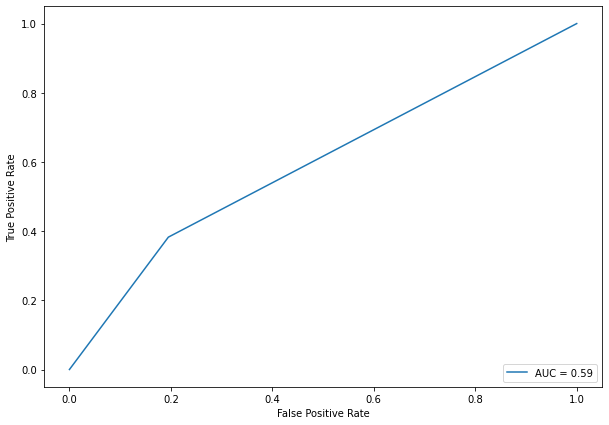

Accuracy:  0.5738636363636364


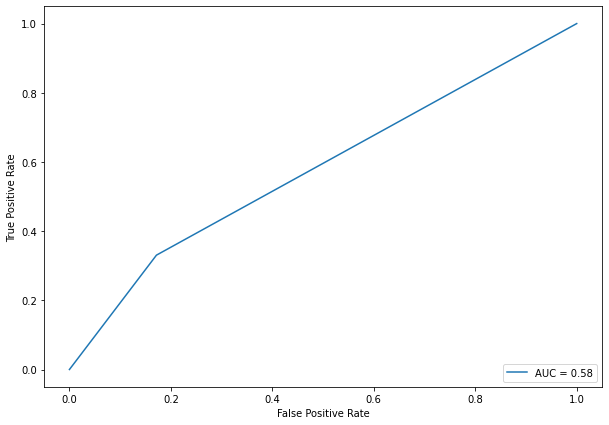

Accuracy:  0.5667613636363636


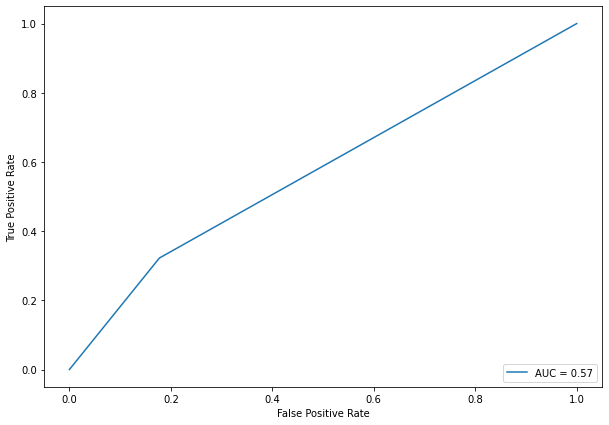

Accuracy:  0.5795454545454546


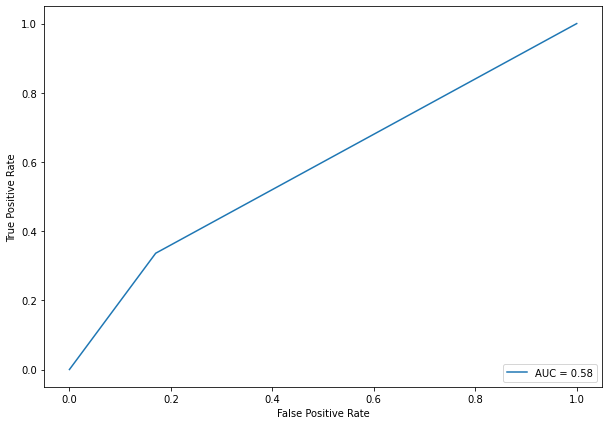

Accuracy:  0.5909090909090909


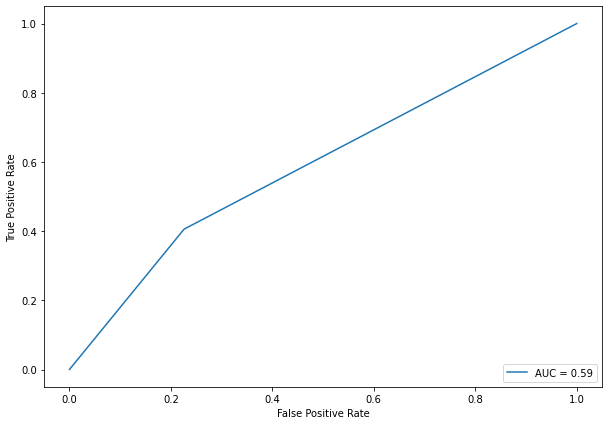

In [31]:
#Clasificador Naive Bayes Gaussiano

z = 0
for subsample in Subsamples:
    XTrain, XTest, YTrain, YTest = train_test_split(subsample.drop(["not.fully.paid"], axis = 1), 
                                                    subsample["not.fully.paid"],
                                                    test_size = 0.3)

    BayesModel = GaussianNB(priors = [0.6,0.4])
    BayesModel.fit(XTrain, YTrain)
    YPredict = BayesModel.predict(XTest)

    print("Accuracy: ", metrics.accuracy_score(YTest, YPredict))
    #Curva Roc
    fpr, tpr, tresh = metrics.roc_curve(YTest, YPredict)
    roc_auc = metrics.auc(fpr, tpr)
    RocCurve = metrics.RocCurveDisplay(fpr = fpr,tpr = tpr, roc_auc = roc_auc)
    RocCurve.plot()
    plt.show()

    pickle.dump(BayesModel, open(r"OutPut\BAYES\Ensemble\Bayes_Ensemble_N" + str(z), "wb"))

    z = z + 1

Oversampled Input Dataframe: 
   credit.policy   purpose  int.rate  installment  log.annual.inc       dti  \
0            0.0  0.833333  0.107417     0.421658        0.456793  0.789052   
1            1.0  1.000000  0.372762     0.879077        0.690924  0.083778   
2            1.0  1.000000  0.417519     0.229223        0.506334  0.136849   
3            0.0  0.833333  0.543478     0.057525        0.512797  0.806409   
4            0.0  1.000000  0.639386     0.165598        0.494868  0.460614   

       fico  days.with.cr.line  revol.bal  revol.util  inq.last.6mths  \
0  0.465116           0.175307   0.048864    0.511949        0.090909   
1  0.883721           0.286985   0.001714    0.036765        0.030303   
2  0.627907           0.149533   0.000128    0.011029        0.181818   
3  0.232558           0.297293   0.008695    0.919118        0.030303   
4  0.255814           0.195925   0.008085    0.498162        0.181818   

   delinq.2yrs  pub.rec  
0          0.0      0.0  
1   

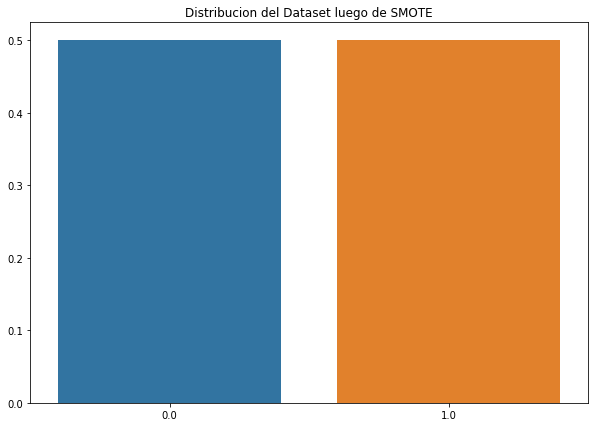

<Figure size 720x504 with 0 Axes>

In [20]:
'''
SUBMUESTREO CON SMOTE
Por último, se aplica de igual forma el submuestreo mediante el 
algoritmo SMOTE, el cual es enfocado a primeramente, el sobremuestreo
de los ejemplos de la clase minoritaria en el dataset de entrenamiento
para seleccionar el modelo apropiado de clasificación; generando, 
muestras aleatorias. De ello, se toma como número de k vecinos igual
a 5, obtenido de una serie de iteraciones, siendo este apropiado para
el caso en cuestión. Consecuentemente, es aplicado en los métodos de
clasificación ya mencionados.
'''
#Metodologia SMOTE
SM = SMOTE(sampling_strategy = 1.0, random_state = random.randrange(200,1000), k_neighbors = 5, n_jobs = 2)

SMDT = NormalizedData.copy()
InputDT, TargetDT = SM.fit_resample(SMDT.drop(["not.fully.paid"], axis = 1), SMDT["not.fully.paid"])
TargetDT = TargetDT.to_frame()
print("Oversampled Input Dataframe: ")
print(InputDT.head())
print("Oversampled Target Dataframe: ")
print(TargetDT.head())

sns.barplot(x = (TargetDT["not.fully.paid"].unique()), 
            y = TargetDT.pivot_table(columns = ["not.fully.paid"], aggfunc = 'size')/TargetDT.shape[0])
plt.title("Distribucion del Dataset luego de SMOTE")
plt.figure(2)
plt.show()

C:\Users\David\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy:  0.5373913043478261


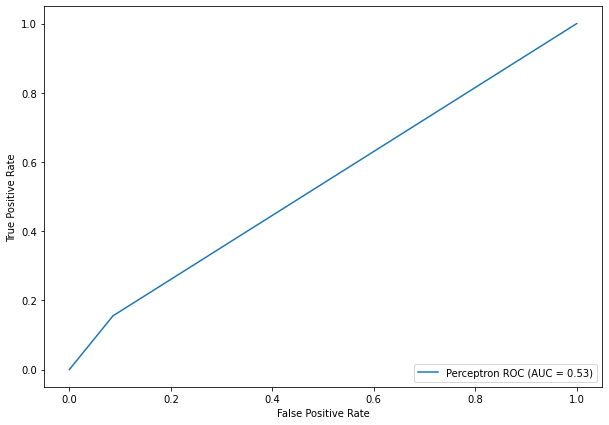

In [33]:
#Red Neuronal

XTrain, XTest, YTrain, YTest = train_test_split(InputDT, TargetDT, test_size = 0.3)

clf = Perceptron(tol=1e-3, random_state= random.randrange(1,9999), n_jobs = 8, class_weight= {0:1, 1:0.7} , max_iter = 2000)
clf.fit(XTrain, YTrain)
YPredict = clf.predict(XTest)

print("Accuracy: ", metrics.accuracy_score(YTest, YPredict))
#Curva ROC
fpr, tpr, tresh = metrics.roc_curve(YTest, YPredict)
roc_auc = metrics.auc(fpr, tpr)
RocCurve = metrics.RocCurveDisplay(fpr = fpr,tpr = tpr, roc_auc = roc_auc, estimator_name = "Perceptron ROC")
RocCurve.plot()
plt.show()

pickle.dump(clf, open(r"OutPut\ANN\SMOTE\Network_Dataset_SMOTE", "wb"))

C:\Users\David\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


K = 1, Accuracy: 0.8643478260869565


C:\Users\David\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Last Accuracy: 0.8643478260869565
K = 2, Accuracy: 0.871055900621118


C:\Users\David\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Last Accuracy: 0.871055900621118
K = 3, Accuracy: 0.8218633540372671


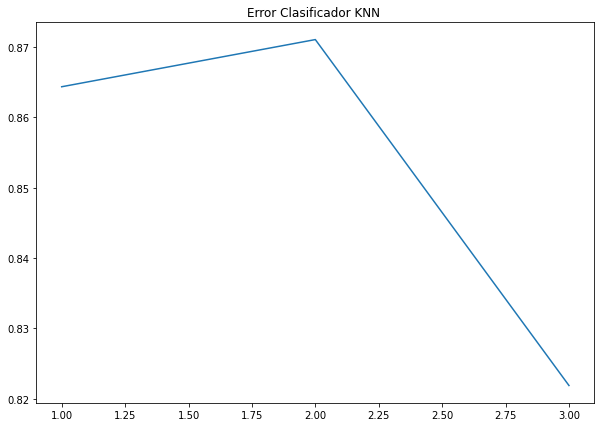

<Figure size 720x504 with 0 Axes>

In [36]:
#Clasificador KNN

XTrain, XTest, YTrain, YTest = train_test_split(InputDT, TargetDT, test_size = 0.3)

K = 1
LastAccuracy = 0

KNNmodel = KNeighborsClassifier(n_neighbors=K)
KNNmodel.fit(XTrain, YTrain)
YPredict = KNNmodel.predict(XTest)
Accuracy = metrics.accuracy_score(YTest, YPredict)
print("K = " + str(K) + ", Accuracy: " + str(Accuracy))

AccuracyPlot = np.array(Accuracy)
KPlot = np.array(K)

o = 0
while (Accuracy > LastAccuracy*0.95) and (o <= 10):
    K = K + 1
    KNNmodel = KNeighborsClassifier(n_neighbors=K)
    KNNmodel.fit(XTrain, YTrain)
    YPredict = KNNmodel.predict(XTest)
    LastAccuracy = Accuracy
    Accuracy = metrics.accuracy_score(YTest, YPredict)
    print("Last Accuracy: " + str(LastAccuracy))
    print("K = " + str(K) + ", Accuracy: " + str(Accuracy))

    AccuracyPlot = np.append(AccuracyPlot, Accuracy)
    KPlot = np.append(KPlot, K)

    if (round(Accuracy,5) == round(LastAccuracy,5)):
        o = o + 1

pickle.dump(KNNmodel, open(r"OutPut\KNN\SMOTE\KNN_SMOTE", "wb"))
plt.plot(KPlot, AccuracyPlot)
plt.title("Error Clasificador KNN ")
plt.figure(4)
plt.show()

C:\Users\David\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy:  0.5890683229813665


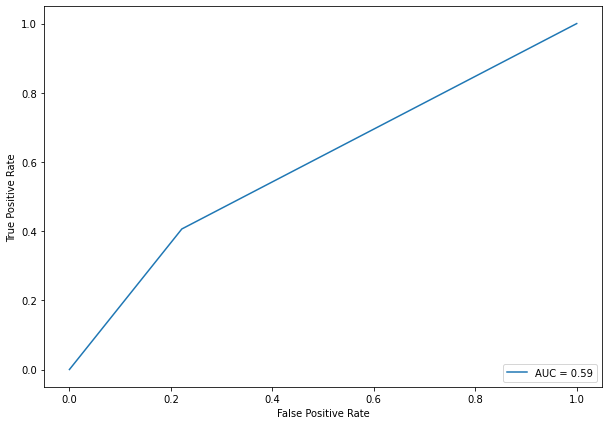

In [38]:
#Clasificador bayesiano

XTrain, XTest, YTrain, YTest = train_test_split(InputDT, TargetDT, test_size = 0.3)

BayesModel = GaussianNB(priors = [0.6,0.4])
BayesModel.fit(XTrain, YTrain)
YPredict = BayesModel.predict(XTest)

print("Accuracy: ", metrics.accuracy_score(YTest, YPredict))
#Curva Roc
fpr, tpr, tresh = metrics.roc_curve(YTest, YPredict)
roc_auc = metrics.auc(fpr, tpr)
RocCurve = metrics.RocCurveDisplay(fpr = fpr,tpr = tpr, roc_auc = roc_auc)
RocCurve.plot()
plt.show()

pickle.dump(BayesModel, open(r"OutPut\BAYES\SMOTE\KNN_SMOTE", "wb"))

In [80]:
#Validacion
print("Validacion de modelos generados")
'''
La validacion de los modelos generados para cada uno de los
tipos de clasificadores anteriormente mencionados consta de
contrastarlos con un dataset de prueba que anteriormente
había sido separado del dataset original, este dataset se
encuentra comprendido por 50% de muestras con prestamos pagos
y 50% de muestras con prestamos no pagos. 

Cabe aclarar que para evaluar el ensemble generado con cada
uno de lo clasificadores seleccionados consta de hallar la
media de las predicciones generadas por cada clasificador y
ponderarlas de tal forma que si la ponderacion supera el limite
de 0.8 está será considerada como 1, si no será considerada como 0.

La evaluacion de los resultados obtenidos constará del uso de las
siguientes medidas de evaluacion:

    1. Precisión: la precisión describé el porcentaje de aciertos que
    obtuvo el clasificador respecto a los datos de prueba.
    (Rango 0 a 1)

    2. Recall: el recall describe la habilidad que posee el clasificador
    al momento de encontrar los verdaderos datos positivos de una clase.
    (Rango 0 a 1)

    3. F1-Score: esté parametro es descrito matematicamente como la
    media harmonica de la precisión y el recall, tiene como objetivo describir
    de manera general el comportamiento del clasificador. (Rango 0 a 1)

    4. Grafico ROC: el grafico ROC describe la sensibilidad (Tasa de verdaderos
    positivos en una clase) y la especificidad (Tasa de verdaderos negativos en
    una clase).

'''

TestDT = (TestDT - TestDT.min())/(TestDT.max() -TestDT.min())

Validacion de modelos generados


Validacion perceptron de unica capa - DatasetCompleto
              precision    recall  f1-score   support

         0.0       0.50      0.98      0.67       130
         1.0       0.67      0.03      0.06       130

    accuracy                           0.51       260
   macro avg       0.59      0.51      0.36       260
weighted avg       0.59      0.51      0.36       260



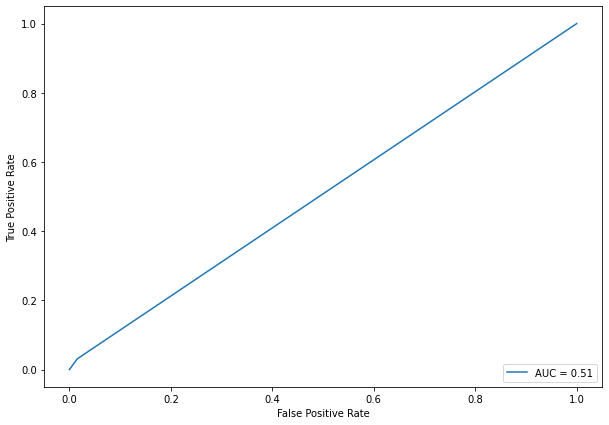

In [81]:
#Validacion Perceptron de unica capa

print("Validacion perceptron de unica capa - DatasetCompleto")

Network_Fulldataset = pickle.load(open(r"OutPut\ANN\FullDataset\Network_Dataset_Completo", "rb"))

YPredict = Network_Fulldataset.predict(TestDT.drop(["not.fully.paid"], axis = 1))

print(metrics.classification_report(TestDT["not.fully.paid"], YPredict))

fpr, tpr, tresh = metrics.roc_curve(TestDT["not.fully.paid"], YPredict)
roc_auc = metrics.auc(fpr, tpr)
RocCurve = metrics.RocCurveDisplay(fpr = fpr,tpr = tpr, roc_auc = roc_auc)
RocCurve.plot()
plt.show()

Validacion perceptron de unica capa - Subsample
              precision    recall  f1-score   support

         0.0       0.69      0.26      0.38       130
         1.0       0.55      0.88      0.67       130

    accuracy                           0.57       260
   macro avg       0.62      0.57      0.53       260
weighted avg       0.62      0.57      0.53       260



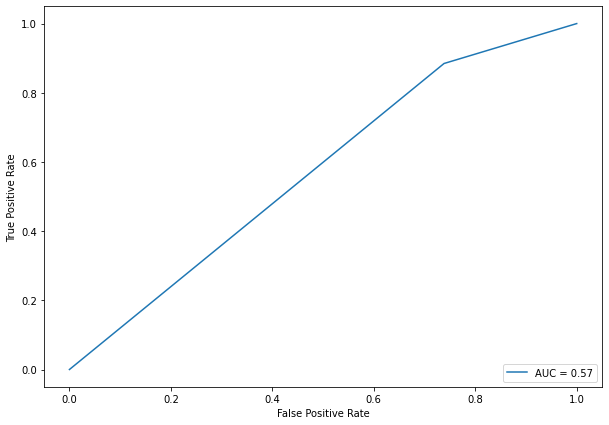

In [82]:
#Validacion Perceptron de unica capa

print("Validacion perceptron de unica capa - Subsample")

Network_Subsample = pickle.load(open(r"OutPut\ANN\Subsample\Network_Subsample_equal", "rb"))

YPredict = Network_Subsample.predict(TestDT.drop(["not.fully.paid"], axis = 1))

print(metrics.classification_report(TestDT["not.fully.paid"], YPredict))

fpr, tpr, tresh = metrics.roc_curve(TestDT["not.fully.paid"], YPredict)
roc_auc = metrics.auc(fpr, tpr)
RocCurve = metrics.RocCurveDisplay(fpr = fpr,tpr = tpr, roc_auc = roc_auc)
RocCurve.plot()
plt.show()

Validacion perceptron de unica capa - SMOTE
              precision    recall  f1-score   support

         0.0       0.56      0.81      0.66       130
         1.0       0.65      0.35      0.46       130

    accuracy                           0.58       260
   macro avg       0.60      0.58      0.56       260
weighted avg       0.60      0.58      0.56       260



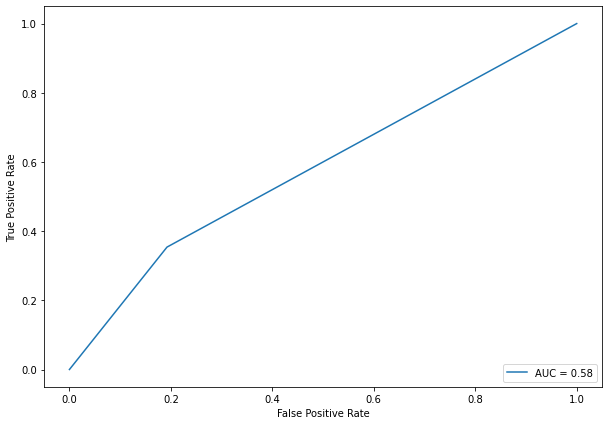

In [83]:
#Validacion Perceptron de unica capa

print("Validacion perceptron de unica capa - SMOTE")

Network_SMOTE = pickle.load(open(r"OutPut\ANN\SMOTE\Network_Dataset_SMOTE", "rb"))

YPredict = Network_SMOTE.predict(TestDT.drop(["not.fully.paid"], axis = 1))

print(metrics.classification_report(TestDT["not.fully.paid"], YPredict))

fpr, tpr, tresh = metrics.roc_curve(TestDT["not.fully.paid"], YPredict)
roc_auc = metrics.auc(fpr, tpr)
RocCurve = metrics.RocCurveDisplay(fpr = fpr,tpr = tpr, roc_auc = roc_auc)
RocCurve.plot()
plt.show()

Validacion perceptron de unica capa - ENSEMBLE
              precision    recall  f1-score   support

         0.0       0.52      0.98      0.68       130
         1.0       0.88      0.11      0.19       130

    accuracy                           0.55       260
   macro avg       0.70      0.55      0.44       260
weighted avg       0.70      0.55      0.44       260



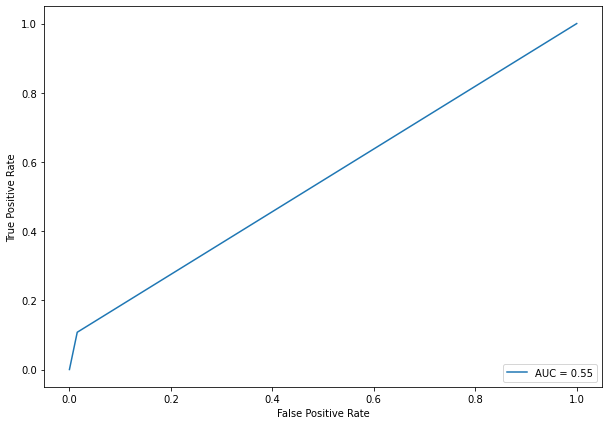

In [84]:
print("Validacion perceptron de unica capa - ENSEMBLE")

Network_ensemble = list()
YPredict = pd.DataFrame({})

z = 0
for subsample in Subsamples:
    Network_ensemble.append(pickle.load(open(r"OutPut\ANN\Ensemble\Network_Ensemble_N" + str(z), "rb")))
    z = z + 1

for Net in Network_ensemble:
    Buffer = pd.DataFrame(Net.predict(TestDT.drop(["not.fully.paid"], axis = 1)))
    YPredict = pd.concat([YPredict,Buffer],axis = 1, copy = True, ignore_index = True)

YPredict = YPredict.mean(axis=1)

for Index in YPredict.index:
    if YPredict[Index] > 0.8:
        YPredict[Index] = 1
    else:
        YPredict[Index] = 0

YPredict = YPredict.astype(int)

print(metrics.classification_report(TestDT["not.fully.paid"], YPredict))

fpr, tpr, tresh = metrics.roc_curve(TestDT["not.fully.paid"], YPredict)
roc_auc = metrics.auc(fpr, tpr)
RocCurve = metrics.RocCurveDisplay(fpr = fpr,tpr = tpr, roc_auc = roc_auc)
RocCurve.plot()
plt.show()

Validacion KNN - Dataset Completo
              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67       130
         1.0       0.00      0.00      0.00       130

    accuracy                           0.50       260
   macro avg       0.25      0.50      0.33       260
weighted avg       0.25      0.50      0.33       260



C:\Users\David\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\David\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\David\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

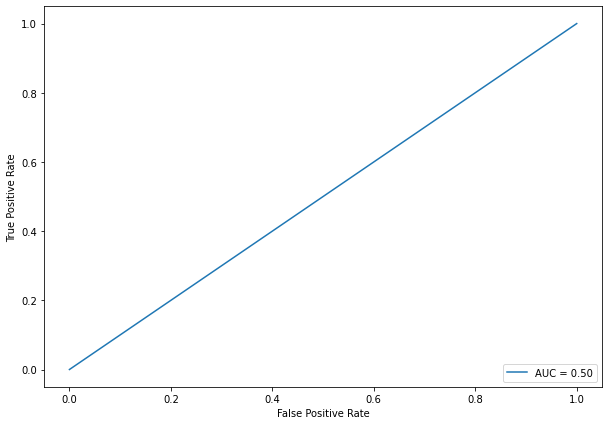

In [85]:
#Validacion KNN

print("Validacion KNN - Dataset Completo")

KNN_Fulldataset = pickle.load(open(r"OutPut\KNN\FullDataset\KNN_FullDataset", "rb"))

YPredict = KNN_Fulldataset.predict(TestDT.drop(["not.fully.paid"], axis = 1))

print(metrics.classification_report(TestDT["not.fully.paid"], YPredict))

fpr, tpr, tresh = metrics.roc_curve(TestDT["not.fully.paid"], YPredict)
roc_auc = metrics.auc(fpr, tpr)
RocCurve = metrics.RocCurveDisplay(fpr = fpr,tpr = tpr, roc_auc = roc_auc)
RocCurve.plot()
plt.show()

Validacion KNN - Subsample
              precision    recall  f1-score   support

         0.0       0.69      0.26      0.38       130
         1.0       0.55      0.88      0.67       130

    accuracy                           0.57       260
   macro avg       0.62      0.57      0.53       260
weighted avg       0.62      0.57      0.53       260



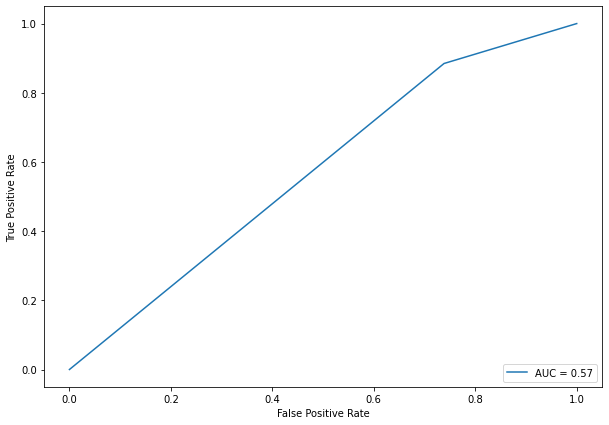

In [86]:
#Validacion KNN

print("Validacion KNN - Subsample")

KNN_Subsample = pickle.load(open(r"OutPut\KNN\Subsample\KNN_Subsample", "rb"))

YPredict = Network_Subsample.predict(TestDT.drop(["not.fully.paid"], axis = 1))

print(metrics.classification_report(TestDT["not.fully.paid"], YPredict))

fpr, tpr, tresh = metrics.roc_curve(TestDT["not.fully.paid"], YPredict)
roc_auc = metrics.auc(fpr, tpr)
RocCurve = metrics.RocCurveDisplay(fpr = fpr,tpr = tpr, roc_auc = roc_auc)
RocCurve.plot()
plt.show()

Validacion KNN - SMOTE
              precision    recall  f1-score   support

         0.0       0.87      0.74      0.80       130
         1.0       0.77      0.89      0.83       130

    accuracy                           0.82       260
   macro avg       0.82      0.82      0.81       260
weighted avg       0.82      0.82      0.81       260



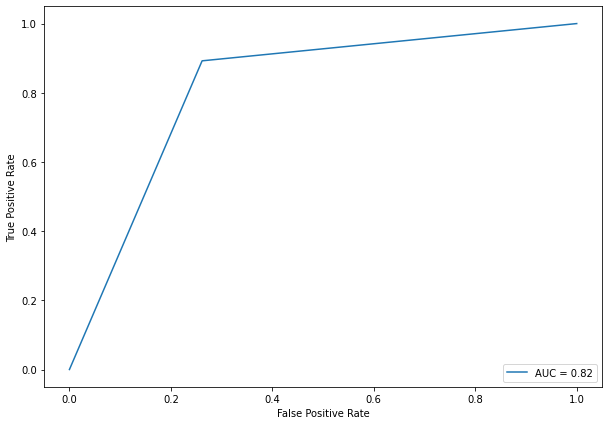

In [87]:
#Validacion KNN

print("Validacion KNN - SMOTE")

KNN_SMOTE = pickle.load(open(r"OutPut\KNN\SMOTE\KNN_SMOTE", "rb"))

YPredict = KNN_SMOTE.predict(TestDT.drop(["not.fully.paid"], axis = 1))

print(metrics.classification_report(TestDT["not.fully.paid"], YPredict))

fpr, tpr, tresh = metrics.roc_curve(TestDT["not.fully.paid"], YPredict)
roc_auc = metrics.auc(fpr, tpr)
RocCurve = metrics.RocCurveDisplay(fpr = fpr,tpr = tpr, roc_auc = roc_auc)
RocCurve.plot()
plt.show()

Validacion KNN - ENSEMBLE
              precision    recall  f1-score   support

         0.0       0.56      0.76      0.64       130
         1.0       0.63      0.40      0.49       130

    accuracy                           0.58       260
   macro avg       0.59      0.58      0.57       260
weighted avg       0.59      0.58      0.57       260



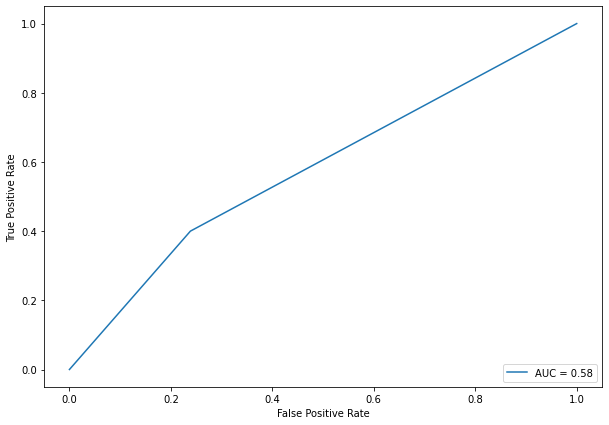

In [88]:
#Validacion KNN
print("Validacion KNN - ENSEMBLE")

KNN_ensemble = list()
YPredict = pd.DataFrame({})

z = 0
for subsample in Subsamples:
    KNN_ensemble.append(pickle.load(open(r"OutPut\KNN\Ensemble\KNN_Ensemble_N" + str(z), "rb")))
    z = z + 1

for Net in KNN_ensemble:
    Buffer = pd.DataFrame(Net.predict(TestDT.drop(["not.fully.paid"], axis = 1)))
    YPredict = pd.concat([YPredict,Buffer],axis = 1, copy = True, ignore_index = True)

YPredict = YPredict.mean(axis=1)

for Index in YPredict.index:
    if YPredict[Index] > 0.8:
        YPredict[Index] = 1
    else:
        YPredict[Index] = 0

YPredict = YPredict.astype(int)

print(metrics.classification_report(TestDT["not.fully.paid"], YPredict))

fpr, tpr, tresh = metrics.roc_curve(TestDT["not.fully.paid"], YPredict)
roc_auc = metrics.auc(fpr, tpr)
RocCurve = metrics.RocCurveDisplay(fpr = fpr,tpr = tpr, roc_auc = roc_auc)
RocCurve.plot()
plt.show()

Validacion BAYES - Dataset Completo
              precision    recall  f1-score   support

         0.0       0.50      1.00      0.67       130
         1.0       0.00      0.00      0.00       130

    accuracy                           0.50       260
   macro avg       0.25      0.50      0.33       260
weighted avg       0.25      0.50      0.33       260



C:\Users\David\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\David\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\David\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

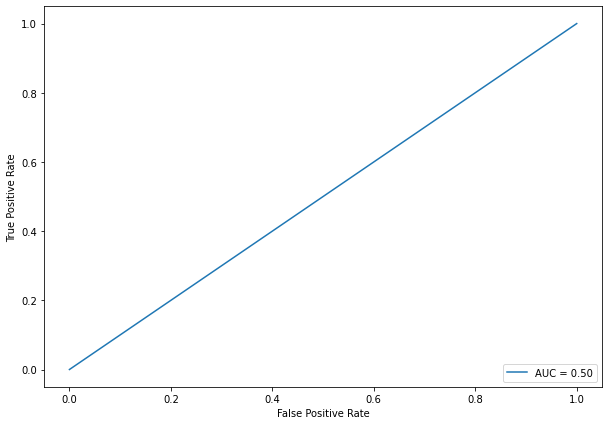

In [89]:
#Validacion BAYES

print("Validacion BAYES - Dataset Completo")

Bayes_Fulldataset = pickle.load(open(r"OutPut\BAYES\FullDataset\Bayes_FullDataset", "rb"))

YPredict = Bayes_Fulldataset.predict(TestDT.drop(["not.fully.paid"], axis = 1))

print(metrics.classification_report(TestDT["not.fully.paid"], YPredict))

fpr, tpr, tresh = metrics.roc_curve(TestDT["not.fully.paid"], YPredict)
roc_auc = metrics.auc(fpr, tpr)
RocCurve = metrics.RocCurveDisplay(fpr = fpr,tpr = tpr, roc_auc = roc_auc)
RocCurve.plot()
plt.show()

Validacion Bayes - Subsample
              precision    recall  f1-score   support

         0.0       0.58      0.62      0.60       130
         1.0       0.60      0.55      0.57       130

    accuracy                           0.59       260
   macro avg       0.59      0.59      0.59       260
weighted avg       0.59      0.59      0.59       260



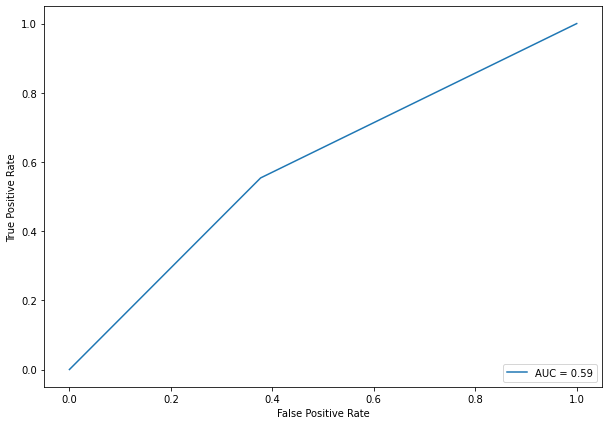

In [90]:
#Validacion Bayes

print("Validacion Bayes - Subsample")

Bayes_Subsample = pickle.load(open(r"OutPut\BAYES\Subsample\Bayes_Subsample", "rb"))

YPredict = Bayes_Subsample.predict(TestDT.drop(["not.fully.paid"], axis = 1))

print(metrics.classification_report(TestDT["not.fully.paid"], YPredict))

fpr, tpr, tresh = metrics.roc_curve(TestDT["not.fully.paid"], YPredict)
roc_auc = metrics.auc(fpr, tpr)
RocCurve = metrics.RocCurveDisplay(fpr = fpr,tpr = tpr, roc_auc = roc_auc)
RocCurve.plot()
plt.show()

Validacion Bayes - SMOTE
              precision    recall  f1-score   support

         0.0       0.54      0.62      0.58       130
         1.0       0.56      0.48      0.52       130

    accuracy                           0.55       260
   macro avg       0.55      0.55      0.55       260
weighted avg       0.55      0.55      0.55       260



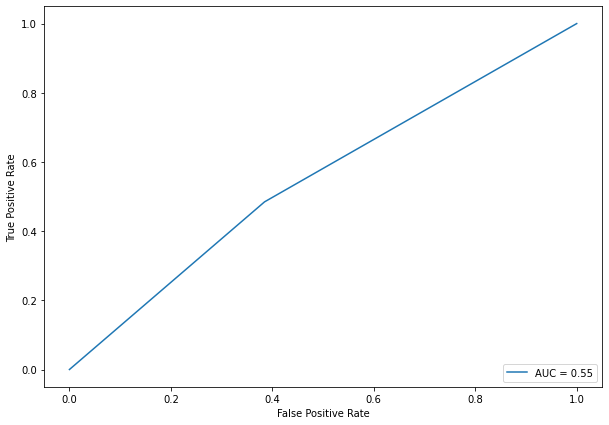

In [91]:
#Validacion Bayes

print("Validacion Bayes - SMOTE")

Bayes_SMOTE = pickle.load(open(r"OutPut\BAYES\SMOTE\KNN_SMOTE", "rb"))

YPredict = Bayes_SMOTE.predict(TestDT.drop(["not.fully.paid"], axis = 1))

print(metrics.classification_report(TestDT["not.fully.paid"], YPredict))

fpr, tpr, tresh = metrics.roc_curve(TestDT["not.fully.paid"], YPredict)
roc_auc = metrics.auc(fpr, tpr)
RocCurve = metrics.RocCurveDisplay(fpr = fpr,tpr = tpr, roc_auc = roc_auc)
RocCurve.plot()
plt.show()

Validacion Bayes - ENSEMBLE
              precision    recall  f1-score   support

         0.0       0.56      0.76      0.64       130
         1.0       0.63      0.40      0.49       130

    accuracy                           0.58       260
   macro avg       0.59      0.58      0.57       260
weighted avg       0.59      0.58      0.57       260



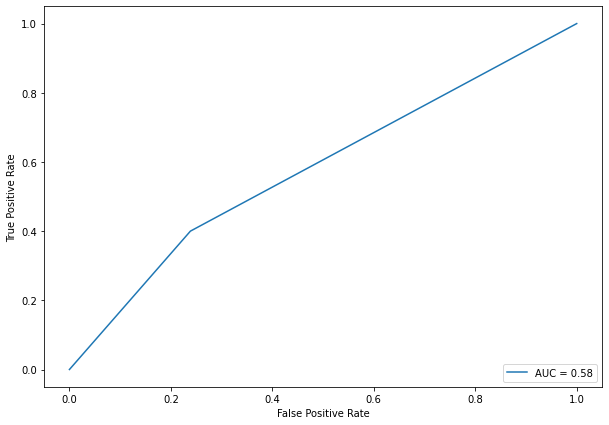

In [92]:
#Validacion Ensemble
print("Validacion Bayes - ENSEMBLE")

Bayes_ensemble = list()
YPredict = pd.DataFrame({})

z = 0
for subsample in Subsamples:
    Bayes_ensemble.append(pickle.load(open(r"OutPut\BAYES\Ensemble\Bayes_Ensemble_N" + str(z), "rb")))
    z = z + 1

for Net in KNN_ensemble:
    Buffer = pd.DataFrame(Net.predict(TestDT.drop(["not.fully.paid"], axis = 1)))
    YPredict = pd.concat([YPredict,Buffer],axis = 1, copy = True, ignore_index = True)

YPredict = YPredict.mean(axis=1)

for Index in YPredict.index:
    if YPredict[Index] > 0.8:
        YPredict[Index] = 1
    else:
        YPredict[Index] = 0

YPredict = YPredict.astype(int)

print(metrics.classification_report(TestDT["not.fully.paid"], YPredict))

fpr, tpr, tresh = metrics.roc_curve(TestDT["not.fully.paid"], YPredict)
roc_auc = metrics.auc(fpr, tpr)
RocCurve = metrics.RocCurveDisplay(fpr = fpr,tpr = tpr, roc_auc = roc_auc)
RocCurve.plot()
plt.show()

In [ ]:
'''
Analisis de resultados

Los resultados del perceptrón de única capa son los siguientes:

Teniendo en cuenta los reportes de rendimiento para cada uno de 
los perceptrones de única capa anteriormente generados estos indican 
que el desempeño del clasificador de forma global no fue optimo y que
donde este obtuvo un mejor rendimiento fue detectando los prestamos 
pagados. Analizando las gráficas ROC, se evidencia que el rango del 
área AUC es igual a 0.5 y 0.57 lo cual indica un comportamiento poco 
asertivo y muy aleatorio al momento de realizar las predicciones. 

Los resultados del clasificador KNN son los siguientes:

Los reportes de rendimiento del algoritmo clasificador KNN a diferencia
del perceptrón de única capa mantuvieron dos tendencias distintas, 
mientras que los clasificadores entrenados con el dataset completo 
con submuestreo y con ensemble obtuvieron rendimientos bajos y aleatorios,
mientras que el clasificador entrenado con SMOTE obtuvieron un mejor 
rendimiento al clasificar los prestamos llegando a obtener una precisión 
del 82% y un rendimiento balanceado para ambos tipos de clases.

Los resultados del clasificador bayesiano son los siguientes:

De manera análoga a la mayoría de clasificadores KNN, los clasificadores 
bayesianos entrenados no obtuvieron un rendimiento adecuado obteniendo 
un máximo de precisión de 59% en el clasificador entrenado mediante submuestreo.

Finalmente es posible concluir que los resultados presentados 
(a excepción del clasificador KNN entrenado con el dataset equilibrado usando SMOTE) 
indican que aún no es posible hacer uso de los clasificadores aquí mostrados y 
que se hace necesario un replanteamiento del dataset empleado debido a que el análisis 
de los resultados presentados y la diferencia que estos poseen con las métricas halladas
durante la fase de entrenamiento indican que no se generó una generalización correcta 
de la clasificación necesaria. Además también se plantea como futuro trabajo estudiar
las condiciones especificas que generaron el rendimiento observado en el clasificador
KNN anteriormente mencionado con la finalidad de replicarlas y evaluar 
la consistencia del entrenamiento.
'''